# Nuova sezione



1.   RICORDA DI PROVARE on epoch end
2.   new tiles weights







# Initial Setup



In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from PIL import Image
import math

# Set the seed for random operations. 
# Letting experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED) 
np.random.seed(SEED)

# Get current working directory
cwd = os.getcwd()

In [3]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jan 19 11:24:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Image preprocessing function

In [5]:
# Mask found in the HSV spectrum
MASK_LIMITS_HSV = ((30,40,70), (80,255,255))

In [6]:
import cv2 as cv
# -----------------------------------------
# Image preprocessing (not used at the end)
# -----------------------------------------
def mask_image(image: np.array):
  
    image_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)

    designed_mask = cv.inRange(image_hsv, *MASK_LIMITS_HSV)

    denoised_mask = cv.morphologyEx(designed_mask, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_RECT, (7,7)))

    dilatated_mask = cv.dilate(denoised_mask, np.ones((5,5),np.uint8), iterations = 3)

    image_masked = cv.bitwise_and(image, image, mask = dilatated_mask)

    return image_masked

# Tiling functions

In [7]:
import glob
import sys
import errno
import warnings
warnings.simplefilter("ignore", UserWarning)

def create_patches(img, patch_height=256, patch_width=256, h_stride=0.5, w_stride=0.5):
    """ 
        Params: img -> Input image(numpy array)
                patch height -> height of patch to be cut
                patch width -> width of patch to be cut
                h_stride -> 1/overlap required among adjacent patch along height eg. 0.5 for twice overlap
                w_stride -> 1/overlap required among adjacent patch along width

        input -> image (height,width,channel), patch dimensions
    	  
        output -> patches of desired dimensions (patch_height, patch_width, channel)
                  patch parameters dictionary containing:
                                                          --original image height
                                                          --original image width
                                                          --stride along height
                                                          --stride along width
                                                          --patch height
                                                          --patch width
    """
    h_stride = int(max(1, patch_height * h_stride))
    w_stride = int(max(1, patch_width * w_stride))

    patch_param = {}
    patch_param['image_height'] = img.shape[0]
    patch_param['image_width'] = img.shape[1]
    patch_param['h_stride'] = h_stride
    patch_param['w_stride'] = w_stride
    patch_param['patch_height'] = patch_height
    patch_param['patch_width'] = patch_width

    h = 0
    w = 0

    img = pad_image(img, patch_height, patch_width, mode='symmetric')

    patches = []

    while h <= img.shape[0] - patch_height:
        w = 0
        while w <= img.shape[1] - patch_width:
            patches.append(img[h:h+patch_height, w:w+patch_width, :])
            w = w + w_stride
        h = h+h_stride

    return patches, patch_param

def return_padding(img, height, width):
    " Return padding given image and height, width of patch"
    h = 0 if img.shape[0]%height == 0 else height - img.shape[0]%height
    w = 0 if img.shape[1]%width == 0 else width - img.shape[1]%width
    pad_shape = tuple(np.zeros((len(img.shape),2),dtype=np.uint16))
    pad_shape = [tuple(x) for x in pad_shape]
    h_left  = h//2
    h_right = h - h_left
    w_left  = w//2
    w_right = w - w_left
    pad_shape[0] = (int(h_left),int(h_right))
    pad_shape[1] = (int(w_left),int(w_right))
    
    print("pad shape is {}".format(pad_shape))
    return pad_shape

def pad_image(img, height, width, channels=4, mode='constant'):
    """ 
        Pads img to make it fit for extracting patches of 
        shape height X width from it
        mode -> constant, reflect
        constant -> pads ith 0's
        symmetric -> pads with reflection of image borders
    """
    print('input shape {}'.format(img.shape))
    pad_shape = return_padding(img, height, width)
    img = np.pad(img,pad_shape, mode = mode)
    print('output shape {}'.format(img.shape))
    return img  


def make_divisor_mask(mask_height, mask_width, step):
    """ Create a mask array defining the overlap extent of patches"""
    mask = np.empty([mask_height, mask_width], dtype=np.uint16)
    for i in range(1,mask_height+1):
        for j in range(1,mask_width+1):
            mask[i-1][j-1] = min(i,mask_height-i+1,step)*min(j,mask_width-j+1,step)
    return mask

def stitch_patch(patches, image_dict, h_stride, w_stride, channel=3):
  """
        Takes the patches of an image and reconstruct the original image by recombining
        the patches using naive overlapping assumption without any smoothing.

        Naive method assumes linear recombination of patches and gives relative weightage to patches with twice overlap.
        
        Params: patches -> list of patches
                image_dict -> dictionary having image height, image width, patch height, patch width
                            with keys- 'image_height', 'image_width', 'patch_height', 'patch_width'
                h_stride -> 1/overlap taken among adjacent patch along height eg. 0.5 for twice overlap
                w_stride -> 1/overlap taken among adjacent patch along width
                channel  -> number of channel in patches

        input -> list of patches to be stiched        
        
        output -> reconstructed image
                
  """
  patch_height = int(image_dict['patch_height'])
  patch_width  = int(image_dict['patch_height'])
  orig_img_height = int(image_dict['image_height'])
  orig_img_width  = int(image_dict['image_width'])
  h_stride = int(h_stride * patch_height)
  w_stride = int(w_stride * patch_width)

  img_dtype = np.float32
  image     = np.zeros((orig_img_height, orig_img_width, channel), dtype = img_dtype)
  padding   = return_padding(image, patch_height, patch_width)
  image     = pad_image(image, patch_height, patch_width, channels = channel, mode = 'constant')
  
  h = 0
  w = 0

  patch_id = 0

  while h <= image.shape[0]-patch_height:
    w = 0
    while w <= image.shape[1]-patch_width:
      image[h:h+patch_height, w:w+patch_width, :] += patches[patch_id]
      w = w + w_stride
      patch_id += 1

    h = h + h_stride

  if(h_stride == w_stride):
    step = patch_height // h_stride
  else:
    print("Unequal strides are not supported")

  mask_height = image.shape[0] // h_stride
  mask_width  = image.shape[1] // w_stride
  divisor_mask = make_divisor_mask(mask_height, mask_width, step)
  print("Divisor mask shape {}".format(divisor_mask.shape))

  h = 0
  w = 0
  mask_h = 0
  mask_w = 0
  print("Image shape {}".format(image.shape))
  while h <= image.shape[0] - h_stride:
    w = 0
    mask_w = 0
    while w <= image.shape[1] - w_stride:
      image[h:h+h_stride, w:w+w_stride,:] /= divisor_mask[mask_h,mask_w]
      w += w_stride
      mask_w +=1
    h += h_stride
    mask_h +=1

  img = image[padding[0][0]:image.shape[0]-padding[0][1], padding[1][0]:image.shape[1]-padding[1][1],:]
  print("FinalImage shape{}".format(img.shape))
  assert img.shape == (orig_img_height, orig_img_width, channel)

  return img

# Dataset Retrieval

In [8]:
# Option to be set to true the first time to RETRIEVE the dataset and split it
# into training and validation. If set to False it expects the dataset to be already 
# splitted and zipped in your drive in the directory "Challenge_2".
SPLIT_DATASET = True

# This option let you use your dataset_split.json file, that must be located in 
# your drive in the directory "Challenge_2", for the dataset split.
# Is considered only if SPLIT_DATASET == True since if SPLIT_DATASET == 
# False the dataset is expected to be already splitted and zipped in your
# drive in the directory "Challenge_2".
LOAD_FROM_JSON = False

# This option should be set to True if you want to use tiling
USE_TILING = True

### Cells executed if: SPLIT_DATASET = True 

In [ ]:
# ----------------------
# Get the zipped dataset 
# ----------------------
if SPLIT_DATASET == True:
  ! unzip '/content/drive/My Drive/Challenge_2/Development_Dataset.zip'
  ! unzip '/content/drive/My Drive/Challenge_2/Final_Dataset.zip'

In [28]:
if SPLIT_DATASET == True:
  import shutil

  teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
  plants = ['Haricot', 'Mais']

  folders = ['Images', 'Masks']

  for t in teams:
    for p in plants:
      for f in folders:

        src_path = os.path.join('/content/Test_Dev', t , p, f)
        dst_path = os.path.join('/content/Development_Dataset/Training', t , p, f)
      
        images_filenames = os.listdir(src_path)

        for img_name in images_filenames:
          img_path = os.path.join(src_path, img_name)
          print()
          shutil.copy(img_path, dst_path)

/content/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_03691.jpg


'/content/Development_Dataset/Training/Bipbip/Haricot/Images/Bipbip_haricot_im_03691.jpg'

/content/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00211.jpg


'/content/Development_Dataset/Training/Bipbip/Haricot/Images/Bipbip_haricot_im_00211.jpg'

/content/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02781.jpg


'/content/Development_Dataset/Training/Bipbip/Haricot/Images/Bipbip_haricot_im_02781.jpg'

/content/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_07331.jpg


'/content/Development_Dataset/Training/Bipbip/Haricot/Images/Bipbip_haricot_im_07331.jpg'

/content/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_01341.jpg


'/content/Development_Dataset/Training/Bipbip/Haricot/Images/Bipbip_haricot_im_01341.jpg'

/content/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02841.jpg


'/content/Development_Dataset/Training/Bipbip/Haricot/Images/Bipbip_haricot_im_02841.jpg'

/content/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00951.jpg


'/content/Development_Dataset/Training/Bipbip/Haricot/Images/Bipbip_haricot_im_00951.jpg'

/content/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02901.jpg


'/content/Development_Dataset/Training/Bipbip/Haricot/Images/Bipbip_haricot_im_02901.jpg'

/content/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_06751.jpg


'/content/Development_Dataset/Training/Bipbip/Haricot/Images/Bipbip_haricot_im_06751.jpg'

/content/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02421.jpg


'/content/Development_Dataset/Training/Bipbip/Haricot/Images/Bipbip_haricot_im_02421.jpg'

/content/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00721.jpg


'/content/Development_Dataset/Training/Bipbip/Haricot/Images/Bipbip_haricot_im_00721.jpg'

/content/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00581.jpg


'/content/Development_Dataset/Training/Bipbip/Haricot/Images/Bipbip_haricot_im_00581.jpg'

/content/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_06581.jpg


'/content/Development_Dataset/Training/Bipbip/Haricot/Images/Bipbip_haricot_im_06581.jpg'

/content/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_07421.jpg


'/content/Development_Dataset/Training/Bipbip/Haricot/Images/Bipbip_haricot_im_07421.jpg'

/content/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_07181.jpg


'/content/Development_Dataset/Training/Bipbip/Haricot/Images/Bipbip_haricot_im_07181.jpg'

/content/Test_Dev/Bipbip/Haricot/Masks/Bipbip_haricot_im_00951.png


'/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_00951.png'

/content/Test_Dev/Bipbip/Haricot/Masks/Bipbip_haricot_im_07421.png


'/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_07421.png'

/content/Test_Dev/Bipbip/Haricot/Masks/Bipbip_haricot_im_06751.png


'/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_06751.png'

/content/Test_Dev/Bipbip/Haricot/Masks/Bipbip_haricot_im_07331.png


'/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_07331.png'

/content/Test_Dev/Bipbip/Haricot/Masks/Bipbip_haricot_im_02901.png


'/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_02901.png'

/content/Test_Dev/Bipbip/Haricot/Masks/Bipbip_haricot_im_00721.png


'/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_00721.png'

/content/Test_Dev/Bipbip/Haricot/Masks/Bipbip_haricot_im_00211.png


'/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_00211.png'

/content/Test_Dev/Bipbip/Haricot/Masks/Bipbip_haricot_im_00581.png


'/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_00581.png'

/content/Test_Dev/Bipbip/Haricot/Masks/Bipbip_haricot_im_02781.png


'/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_02781.png'

/content/Test_Dev/Bipbip/Haricot/Masks/Bipbip_haricot_im_02421.png


'/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_02421.png'

/content/Test_Dev/Bipbip/Haricot/Masks/Bipbip_haricot_im_02841.png


'/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_02841.png'

/content/Test_Dev/Bipbip/Haricot/Masks/Bipbip_haricot_im_03691.png


'/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_03691.png'

/content/Test_Dev/Bipbip/Haricot/Masks/Bipbip_haricot_im_07181.png


'/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_07181.png'

/content/Test_Dev/Bipbip/Haricot/Masks/Bipbip_haricot_im_01341.png


'/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_01341.png'

/content/Test_Dev/Bipbip/Haricot/Masks/Bipbip_haricot_im_06581.png


'/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_06581.png'

/content/Test_Dev/Bipbip/Mais/Images/Bipbip_mais_im_09571.jpg


'/content/Development_Dataset/Training/Bipbip/Mais/Images/Bipbip_mais_im_09571.jpg'

/content/Test_Dev/Bipbip/Mais/Images/Bipbip_mais_im_02211.jpg


'/content/Development_Dataset/Training/Bipbip/Mais/Images/Bipbip_mais_im_02211.jpg'

/content/Test_Dev/Bipbip/Mais/Images/Bipbip_mais_im_09781.jpg


'/content/Development_Dataset/Training/Bipbip/Mais/Images/Bipbip_mais_im_09781.jpg'

/content/Test_Dev/Bipbip/Mais/Images/Bipbip_mais_im_06831.jpg


'/content/Development_Dataset/Training/Bipbip/Mais/Images/Bipbip_mais_im_06831.jpg'

/content/Test_Dev/Bipbip/Mais/Images/Bipbip_mais_im_03621.jpg


'/content/Development_Dataset/Training/Bipbip/Mais/Images/Bipbip_mais_im_03621.jpg'

/content/Test_Dev/Bipbip/Mais/Images/Bipbip_mais_im_06381.jpg


'/content/Development_Dataset/Training/Bipbip/Mais/Images/Bipbip_mais_im_06381.jpg'

/content/Test_Dev/Bipbip/Mais/Images/Bipbip_mais_im_10941.jpg


'/content/Development_Dataset/Training/Bipbip/Mais/Images/Bipbip_mais_im_10941.jpg'

/content/Test_Dev/Bipbip/Mais/Images/Bipbip_mais_im_04121.jpg


'/content/Development_Dataset/Training/Bipbip/Mais/Images/Bipbip_mais_im_04121.jpg'

/content/Test_Dev/Bipbip/Mais/Images/Bipbip_mais_im_01931.jpg


'/content/Development_Dataset/Training/Bipbip/Mais/Images/Bipbip_mais_im_01931.jpg'

/content/Test_Dev/Bipbip/Mais/Images/Bipbip_mais_im_07681.jpg


'/content/Development_Dataset/Training/Bipbip/Mais/Images/Bipbip_mais_im_07681.jpg'

/content/Test_Dev/Bipbip/Mais/Images/Bipbip_mais_im_10441.jpg


'/content/Development_Dataset/Training/Bipbip/Mais/Images/Bipbip_mais_im_10441.jpg'

/content/Test_Dev/Bipbip/Mais/Images/Bipbip_mais_im_05521.jpg


'/content/Development_Dataset/Training/Bipbip/Mais/Images/Bipbip_mais_im_05521.jpg'

/content/Test_Dev/Bipbip/Mais/Images/Bipbip_mais_im_07611.jpg


'/content/Development_Dataset/Training/Bipbip/Mais/Images/Bipbip_mais_im_07611.jpg'

/content/Test_Dev/Bipbip/Mais/Images/Bipbip_mais_im_11021.jpg


'/content/Development_Dataset/Training/Bipbip/Mais/Images/Bipbip_mais_im_11021.jpg'

/content/Test_Dev/Bipbip/Mais/Images/Bipbip_mais_im_09091.jpg


'/content/Development_Dataset/Training/Bipbip/Mais/Images/Bipbip_mais_im_09091.jpg'

/content/Test_Dev/Bipbip/Mais/Masks/Bipbip_mais_im_11021.png


'/content/Development_Dataset/Training/Bipbip/Mais/Masks/Bipbip_mais_im_11021.png'

/content/Test_Dev/Bipbip/Mais/Masks/Bipbip_mais_im_09781.png


'/content/Development_Dataset/Training/Bipbip/Mais/Masks/Bipbip_mais_im_09781.png'

/content/Test_Dev/Bipbip/Mais/Masks/Bipbip_mais_im_07611.png


'/content/Development_Dataset/Training/Bipbip/Mais/Masks/Bipbip_mais_im_07611.png'

/content/Test_Dev/Bipbip/Mais/Masks/Bipbip_mais_im_09571.png


'/content/Development_Dataset/Training/Bipbip/Mais/Masks/Bipbip_mais_im_09571.png'

/content/Test_Dev/Bipbip/Mais/Masks/Bipbip_mais_im_05521.png


'/content/Development_Dataset/Training/Bipbip/Mais/Masks/Bipbip_mais_im_05521.png'

/content/Test_Dev/Bipbip/Mais/Masks/Bipbip_mais_im_10441.png


'/content/Development_Dataset/Training/Bipbip/Mais/Masks/Bipbip_mais_im_10441.png'

/content/Test_Dev/Bipbip/Mais/Masks/Bipbip_mais_im_06831.png


'/content/Development_Dataset/Training/Bipbip/Mais/Masks/Bipbip_mais_im_06831.png'

/content/Test_Dev/Bipbip/Mais/Masks/Bipbip_mais_im_03621.png


'/content/Development_Dataset/Training/Bipbip/Mais/Masks/Bipbip_mais_im_03621.png'

/content/Test_Dev/Bipbip/Mais/Masks/Bipbip_mais_im_10941.png


'/content/Development_Dataset/Training/Bipbip/Mais/Masks/Bipbip_mais_im_10941.png'

/content/Test_Dev/Bipbip/Mais/Masks/Bipbip_mais_im_09091.png


'/content/Development_Dataset/Training/Bipbip/Mais/Masks/Bipbip_mais_im_09091.png'

/content/Test_Dev/Bipbip/Mais/Masks/Bipbip_mais_im_06381.png


'/content/Development_Dataset/Training/Bipbip/Mais/Masks/Bipbip_mais_im_06381.png'

/content/Test_Dev/Bipbip/Mais/Masks/Bipbip_mais_im_07681.png


'/content/Development_Dataset/Training/Bipbip/Mais/Masks/Bipbip_mais_im_07681.png'

/content/Test_Dev/Bipbip/Mais/Masks/Bipbip_mais_im_02211.png


'/content/Development_Dataset/Training/Bipbip/Mais/Masks/Bipbip_mais_im_02211.png'

/content/Test_Dev/Bipbip/Mais/Masks/Bipbip_mais_im_04121.png


'/content/Development_Dataset/Training/Bipbip/Mais/Masks/Bipbip_mais_im_04121.png'

/content/Test_Dev/Bipbip/Mais/Masks/Bipbip_mais_im_01931.png


'/content/Development_Dataset/Training/Bipbip/Mais/Masks/Bipbip_mais_im_01931.png'

/content/Test_Dev/Pead/Haricot/Images/Pead_haricot_00340_i750.jpg


'/content/Development_Dataset/Training/Pead/Haricot/Images/Pead_haricot_00340_i750.jpg'

/content/Test_Dev/Pead/Haricot/Images/Pead_haricot_00641_i750.jpg


'/content/Development_Dataset/Training/Pead/Haricot/Images/Pead_haricot_00641_i750.jpg'

/content/Test_Dev/Pead/Haricot/Images/Pead_haricot_00353_i750.jpg


'/content/Development_Dataset/Training/Pead/Haricot/Images/Pead_haricot_00353_i750.jpg'

/content/Test_Dev/Pead/Haricot/Images/Pead_haricot_00648_i750.jpg


'/content/Development_Dataset/Training/Pead/Haricot/Images/Pead_haricot_00648_i750.jpg'

/content/Test_Dev/Pead/Haricot/Images/Pead_haricot_00704_i750.jpg


'/content/Development_Dataset/Training/Pead/Haricot/Images/Pead_haricot_00704_i750.jpg'

/content/Test_Dev/Pead/Haricot/Images/Pead_haricot_00605_i750.jpg


'/content/Development_Dataset/Training/Pead/Haricot/Images/Pead_haricot_00605_i750.jpg'

/content/Test_Dev/Pead/Haricot/Images/Pead_haricot_00628_i750.jpg


'/content/Development_Dataset/Training/Pead/Haricot/Images/Pead_haricot_00628_i750.jpg'

/content/Test_Dev/Pead/Haricot/Images/Pead_haricot_00427_i750.jpg


'/content/Development_Dataset/Training/Pead/Haricot/Images/Pead_haricot_00427_i750.jpg'

/content/Test_Dev/Pead/Haricot/Images/Pead_haricot_00239_i750.jpg


'/content/Development_Dataset/Training/Pead/Haricot/Images/Pead_haricot_00239_i750.jpg'

/content/Test_Dev/Pead/Haricot/Images/Pead_haricot_00143_i750.jpg


'/content/Development_Dataset/Training/Pead/Haricot/Images/Pead_haricot_00143_i750.jpg'

/content/Test_Dev/Pead/Haricot/Images/Pead_haricot_00631_i750.jpg


'/content/Development_Dataset/Training/Pead/Haricot/Images/Pead_haricot_00631_i750.jpg'

/content/Test_Dev/Pead/Haricot/Images/Pead_haricot_00291_i750.jpg


'/content/Development_Dataset/Training/Pead/Haricot/Images/Pead_haricot_00291_i750.jpg'

/content/Test_Dev/Pead/Haricot/Images/Pead_haricot_00130_i750.jpg


'/content/Development_Dataset/Training/Pead/Haricot/Images/Pead_haricot_00130_i750.jpg'

/content/Test_Dev/Pead/Haricot/Images/Pead_haricot_00463_i750.jpg


'/content/Development_Dataset/Training/Pead/Haricot/Images/Pead_haricot_00463_i750.jpg'

/content/Test_Dev/Pead/Haricot/Images/Pead_haricot_00682_i750.jpg


'/content/Development_Dataset/Training/Pead/Haricot/Images/Pead_haricot_00682_i750.jpg'

/content/Test_Dev/Pead/Haricot/Masks/Pead_haricot_00340_i750.png


'/content/Development_Dataset/Training/Pead/Haricot/Masks/Pead_haricot_00340_i750.png'

/content/Test_Dev/Pead/Haricot/Masks/Pead_haricot_00239_i750.png


'/content/Development_Dataset/Training/Pead/Haricot/Masks/Pead_haricot_00239_i750.png'

/content/Test_Dev/Pead/Haricot/Masks/Pead_haricot_00143_i750.png


'/content/Development_Dataset/Training/Pead/Haricot/Masks/Pead_haricot_00143_i750.png'

/content/Test_Dev/Pead/Haricot/Masks/Pead_haricot_00427_i750.png


'/content/Development_Dataset/Training/Pead/Haricot/Masks/Pead_haricot_00427_i750.png'

/content/Test_Dev/Pead/Haricot/Masks/Pead_haricot_00682_i750.png


'/content/Development_Dataset/Training/Pead/Haricot/Masks/Pead_haricot_00682_i750.png'

/content/Test_Dev/Pead/Haricot/Masks/Pead_haricot_00605_i750.png


'/content/Development_Dataset/Training/Pead/Haricot/Masks/Pead_haricot_00605_i750.png'

/content/Test_Dev/Pead/Haricot/Masks/Pead_haricot_00291_i750.png


'/content/Development_Dataset/Training/Pead/Haricot/Masks/Pead_haricot_00291_i750.png'

/content/Test_Dev/Pead/Haricot/Masks/Pead_haricot_00704_i750.png


'/content/Development_Dataset/Training/Pead/Haricot/Masks/Pead_haricot_00704_i750.png'

/content/Test_Dev/Pead/Haricot/Masks/Pead_haricot_00648_i750.png


'/content/Development_Dataset/Training/Pead/Haricot/Masks/Pead_haricot_00648_i750.png'

/content/Test_Dev/Pead/Haricot/Masks/Pead_haricot_00628_i750.png


'/content/Development_Dataset/Training/Pead/Haricot/Masks/Pead_haricot_00628_i750.png'

/content/Test_Dev/Pead/Haricot/Masks/Pead_haricot_00353_i750.png


'/content/Development_Dataset/Training/Pead/Haricot/Masks/Pead_haricot_00353_i750.png'

/content/Test_Dev/Pead/Haricot/Masks/Pead_haricot_00641_i750.png


'/content/Development_Dataset/Training/Pead/Haricot/Masks/Pead_haricot_00641_i750.png'

/content/Test_Dev/Pead/Haricot/Masks/Pead_haricot_00130_i750.png


'/content/Development_Dataset/Training/Pead/Haricot/Masks/Pead_haricot_00130_i750.png'

/content/Test_Dev/Pead/Haricot/Masks/Pead_haricot_00631_i750.png


'/content/Development_Dataset/Training/Pead/Haricot/Masks/Pead_haricot_00631_i750.png'

/content/Test_Dev/Pead/Haricot/Masks/Pead_haricot_00463_i750.png


'/content/Development_Dataset/Training/Pead/Haricot/Masks/Pead_haricot_00463_i750.png'

/content/Test_Dev/Pead/Mais/Images/Pead_mais_00723_i900.jpg


'/content/Development_Dataset/Training/Pead/Mais/Images/Pead_mais_00723_i900.jpg'

/content/Test_Dev/Pead/Mais/Images/Pead_mais_00427_i900.jpg


'/content/Development_Dataset/Training/Pead/Mais/Images/Pead_mais_00427_i900.jpg'

/content/Test_Dev/Pead/Mais/Images/Pead_mais_00229_i900.jpg


'/content/Development_Dataset/Training/Pead/Mais/Images/Pead_mais_00229_i900.jpg'

/content/Test_Dev/Pead/Mais/Images/Pead_mais_00679_i900.jpg


'/content/Development_Dataset/Training/Pead/Mais/Images/Pead_mais_00679_i900.jpg'

/content/Test_Dev/Pead/Mais/Images/Pead_mais_00308_i900.jpg


'/content/Development_Dataset/Training/Pead/Mais/Images/Pead_mais_00308_i900.jpg'

/content/Test_Dev/Pead/Mais/Images/Pead_mais_00395_i900.jpg


'/content/Development_Dataset/Training/Pead/Mais/Images/Pead_mais_00395_i900.jpg'

/content/Test_Dev/Pead/Mais/Images/Pead_mais_00346_i900.jpg


'/content/Development_Dataset/Training/Pead/Mais/Images/Pead_mais_00346_i900.jpg'

/content/Test_Dev/Pead/Mais/Images/Pead_mais_00595_i900.jpg


'/content/Development_Dataset/Training/Pead/Mais/Images/Pead_mais_00595_i900.jpg'

/content/Test_Dev/Pead/Mais/Images/Pead_mais_00556_i900.jpg


'/content/Development_Dataset/Training/Pead/Mais/Images/Pead_mais_00556_i900.jpg'

/content/Test_Dev/Pead/Mais/Images/Pead_mais_00206_i900.jpg


'/content/Development_Dataset/Training/Pead/Mais/Images/Pead_mais_00206_i900.jpg'

/content/Test_Dev/Pead/Mais/Images/Pead_mais_00796_i900.jpg


'/content/Development_Dataset/Training/Pead/Mais/Images/Pead_mais_00796_i900.jpg'

/content/Test_Dev/Pead/Mais/Images/Pead_mais_00387_i900.jpg


'/content/Development_Dataset/Training/Pead/Mais/Images/Pead_mais_00387_i900.jpg'

/content/Test_Dev/Pead/Mais/Images/Pead_mais_00584_i900.jpg


'/content/Development_Dataset/Training/Pead/Mais/Images/Pead_mais_00584_i900.jpg'

/content/Test_Dev/Pead/Mais/Images/Pead_mais_00459_i900.jpg


'/content/Development_Dataset/Training/Pead/Mais/Images/Pead_mais_00459_i900.jpg'

/content/Test_Dev/Pead/Mais/Images/Pead_mais_00173_i900.jpg


'/content/Development_Dataset/Training/Pead/Mais/Images/Pead_mais_00173_i900.jpg'

/content/Test_Dev/Pead/Mais/Masks/Pead_mais_00229_i900.png


'/content/Development_Dataset/Training/Pead/Mais/Masks/Pead_mais_00229_i900.png'

/content/Test_Dev/Pead/Mais/Masks/Pead_mais_00173_i900.png


'/content/Development_Dataset/Training/Pead/Mais/Masks/Pead_mais_00173_i900.png'

/content/Test_Dev/Pead/Mais/Masks/Pead_mais_00308_i900.png


'/content/Development_Dataset/Training/Pead/Mais/Masks/Pead_mais_00308_i900.png'

/content/Test_Dev/Pead/Mais/Masks/Pead_mais_00723_i900.png


'/content/Development_Dataset/Training/Pead/Mais/Masks/Pead_mais_00723_i900.png'

/content/Test_Dev/Pead/Mais/Masks/Pead_mais_00387_i900.png


'/content/Development_Dataset/Training/Pead/Mais/Masks/Pead_mais_00387_i900.png'

/content/Test_Dev/Pead/Mais/Masks/Pead_mais_00584_i900.png


'/content/Development_Dataset/Training/Pead/Mais/Masks/Pead_mais_00584_i900.png'

/content/Test_Dev/Pead/Mais/Masks/Pead_mais_00459_i900.png


'/content/Development_Dataset/Training/Pead/Mais/Masks/Pead_mais_00459_i900.png'

/content/Test_Dev/Pead/Mais/Masks/Pead_mais_00556_i900.png


'/content/Development_Dataset/Training/Pead/Mais/Masks/Pead_mais_00556_i900.png'

/content/Test_Dev/Pead/Mais/Masks/Pead_mais_00427_i900.png


'/content/Development_Dataset/Training/Pead/Mais/Masks/Pead_mais_00427_i900.png'

/content/Test_Dev/Pead/Mais/Masks/Pead_mais_00796_i900.png


'/content/Development_Dataset/Training/Pead/Mais/Masks/Pead_mais_00796_i900.png'

/content/Test_Dev/Pead/Mais/Masks/Pead_mais_00595_i900.png


'/content/Development_Dataset/Training/Pead/Mais/Masks/Pead_mais_00595_i900.png'

/content/Test_Dev/Pead/Mais/Masks/Pead_mais_00395_i900.png


'/content/Development_Dataset/Training/Pead/Mais/Masks/Pead_mais_00395_i900.png'

/content/Test_Dev/Pead/Mais/Masks/Pead_mais_00679_i900.png


'/content/Development_Dataset/Training/Pead/Mais/Masks/Pead_mais_00679_i900.png'

/content/Test_Dev/Pead/Mais/Masks/Pead_mais_00206_i900.png


'/content/Development_Dataset/Training/Pead/Mais/Masks/Pead_mais_00206_i900.png'

/content/Test_Dev/Pead/Mais/Masks/Pead_mais_00346_i900.png


'/content/Development_Dataset/Training/Pead/Mais/Masks/Pead_mais_00346_i900.png'

/content/Test_Dev/Roseau/Haricot/Images/Roseau_haricot_0256_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Images/Roseau_haricot_0256_false.png'

/content/Test_Dev/Roseau/Haricot/Images/Roseau_haricot_0300_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Images/Roseau_haricot_0300_false.png'

/content/Test_Dev/Roseau/Haricot/Images/Roseau_haricot_0396_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Images/Roseau_haricot_0396_false.png'

/content/Test_Dev/Roseau/Haricot/Images/Roseau_haricot_0188_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Images/Roseau_haricot_0188_false.png'

/content/Test_Dev/Roseau/Haricot/Images/Roseau_haricot_0414_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Images/Roseau_haricot_0414_false.png'

/content/Test_Dev/Roseau/Haricot/Images/Roseau_haricot_0372_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Images/Roseau_haricot_0372_false.png'

/content/Test_Dev/Roseau/Haricot/Images/Roseau_haricot_0156_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Images/Roseau_haricot_0156_false.png'

/content/Test_Dev/Roseau/Haricot/Images/Roseau_haricot_0292_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Images/Roseau_haricot_0292_false.png'

/content/Test_Dev/Roseau/Haricot/Images/Roseau_haricot_0074_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Images/Roseau_haricot_0074_false.png'

/content/Test_Dev/Roseau/Haricot/Images/Roseau_haricot_0150_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Images/Roseau_haricot_0150_false.png'

/content/Test_Dev/Roseau/Haricot/Images/Roseau_haricot_0220_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Images/Roseau_haricot_0220_false.png'

/content/Test_Dev/Roseau/Haricot/Images/Roseau_haricot_0010_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Images/Roseau_haricot_0010_false.png'

/content/Test_Dev/Roseau/Haricot/Images/Roseau_haricot_0224_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Images/Roseau_haricot_0224_false.png'

/content/Test_Dev/Roseau/Haricot/Images/Roseau_haricot_0018_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Images/Roseau_haricot_0018_false.png'

/content/Test_Dev/Roseau/Haricot/Images/Roseau_haricot_0228_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Images/Roseau_haricot_0228_false.png'

/content/Test_Dev/Roseau/Haricot/Masks/Roseau_haricot_0256_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Masks/Roseau_haricot_0256_false.png'

/content/Test_Dev/Roseau/Haricot/Masks/Roseau_haricot_0300_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Masks/Roseau_haricot_0300_false.png'

/content/Test_Dev/Roseau/Haricot/Masks/Roseau_haricot_0396_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Masks/Roseau_haricot_0396_false.png'

/content/Test_Dev/Roseau/Haricot/Masks/Roseau_haricot_0188_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Masks/Roseau_haricot_0188_false.png'

/content/Test_Dev/Roseau/Haricot/Masks/Roseau_haricot_0414_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Masks/Roseau_haricot_0414_false.png'

/content/Test_Dev/Roseau/Haricot/Masks/Roseau_haricot_0372_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Masks/Roseau_haricot_0372_false.png'

/content/Test_Dev/Roseau/Haricot/Masks/Roseau_haricot_0156_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Masks/Roseau_haricot_0156_false.png'

/content/Test_Dev/Roseau/Haricot/Masks/Roseau_haricot_0292_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Masks/Roseau_haricot_0292_false.png'

/content/Test_Dev/Roseau/Haricot/Masks/Roseau_haricot_0074_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Masks/Roseau_haricot_0074_false.png'

/content/Test_Dev/Roseau/Haricot/Masks/Roseau_haricot_0150_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Masks/Roseau_haricot_0150_false.png'

/content/Test_Dev/Roseau/Haricot/Masks/Roseau_haricot_0220_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Masks/Roseau_haricot_0220_false.png'

/content/Test_Dev/Roseau/Haricot/Masks/Roseau_haricot_0010_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Masks/Roseau_haricot_0010_false.png'

/content/Test_Dev/Roseau/Haricot/Masks/Roseau_haricot_0224_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Masks/Roseau_haricot_0224_false.png'

/content/Test_Dev/Roseau/Haricot/Masks/Roseau_haricot_0018_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Masks/Roseau_haricot_0018_false.png'

/content/Test_Dev/Roseau/Haricot/Masks/Roseau_haricot_0228_false.png


'/content/Development_Dataset/Training/Roseau/Haricot/Masks/Roseau_haricot_0228_false.png'

/content/Test_Dev/Roseau/Mais/Images/Roseau_mais_0098_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Images/Roseau_mais_0098_false.png'

/content/Test_Dev/Roseau/Mais/Images/Roseau_mais_0056_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Images/Roseau_mais_0056_false.png'

/content/Test_Dev/Roseau/Mais/Images/Roseau_mais_0184_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Images/Roseau_mais_0184_false.png'

/content/Test_Dev/Roseau/Mais/Images/Roseau_mais_0142_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Images/Roseau_mais_0142_false.png'

/content/Test_Dev/Roseau/Mais/Images/Roseau_mais_0286_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Images/Roseau_mais_0286_false.png'

/content/Test_Dev/Roseau/Mais/Images/Roseau_mais_0030_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Images/Roseau_mais_0030_false.png'

/content/Test_Dev/Roseau/Mais/Images/Roseau_mais_0068_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Images/Roseau_mais_0068_false.png'

/content/Test_Dev/Roseau/Mais/Images/Roseau_mais_0008_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Images/Roseau_mais_0008_false.png'

/content/Test_Dev/Roseau/Mais/Images/Roseau_mais_0188_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Images/Roseau_mais_0188_false.png'

/content/Test_Dev/Roseau/Mais/Images/Roseau_mais_0366_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Images/Roseau_mais_0366_false.png'

/content/Test_Dev/Roseau/Mais/Images/Roseau_mais_0332_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Images/Roseau_mais_0332_false.png'

/content/Test_Dev/Roseau/Mais/Images/Roseau_mais_0214_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Images/Roseau_mais_0214_false.png'

/content/Test_Dev/Roseau/Mais/Images/Roseau_mais_0174_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Images/Roseau_mais_0174_false.png'

/content/Test_Dev/Roseau/Mais/Images/Roseau_mais_0074_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Images/Roseau_mais_0074_false.png'

/content/Test_Dev/Roseau/Mais/Images/Roseau_mais_0322_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Images/Roseau_mais_0322_false.png'

/content/Test_Dev/Roseau/Mais/Masks/Roseau_mais_0098_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Masks/Roseau_mais_0098_false.png'

/content/Test_Dev/Roseau/Mais/Masks/Roseau_mais_0056_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Masks/Roseau_mais_0056_false.png'

/content/Test_Dev/Roseau/Mais/Masks/Roseau_mais_0184_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Masks/Roseau_mais_0184_false.png'

/content/Test_Dev/Roseau/Mais/Masks/Roseau_mais_0142_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Masks/Roseau_mais_0142_false.png'

/content/Test_Dev/Roseau/Mais/Masks/Roseau_mais_0286_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Masks/Roseau_mais_0286_false.png'

/content/Test_Dev/Roseau/Mais/Masks/Roseau_mais_0030_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Masks/Roseau_mais_0030_false.png'

/content/Test_Dev/Roseau/Mais/Masks/Roseau_mais_0068_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Masks/Roseau_mais_0068_false.png'

/content/Test_Dev/Roseau/Mais/Masks/Roseau_mais_0008_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Masks/Roseau_mais_0008_false.png'

/content/Test_Dev/Roseau/Mais/Masks/Roseau_mais_0188_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Masks/Roseau_mais_0188_false.png'

/content/Test_Dev/Roseau/Mais/Masks/Roseau_mais_0366_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Masks/Roseau_mais_0366_false.png'

/content/Test_Dev/Roseau/Mais/Masks/Roseau_mais_0332_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Masks/Roseau_mais_0332_false.png'

/content/Test_Dev/Roseau/Mais/Masks/Roseau_mais_0214_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Masks/Roseau_mais_0214_false.png'

/content/Test_Dev/Roseau/Mais/Masks/Roseau_mais_0174_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Masks/Roseau_mais_0174_false.png'

/content/Test_Dev/Roseau/Mais/Masks/Roseau_mais_0074_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Masks/Roseau_mais_0074_false.png'

/content/Test_Dev/Roseau/Mais/Masks/Roseau_mais_0322_false.png


'/content/Development_Dataset/Training/Roseau/Mais/Masks/Roseau_mais_0322_false.png'

/content/Test_Dev/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T114537-44.jpg


'/content/Development_Dataset/Training/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T114537-44.jpg'

/content/Test_Dev/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T114558-52.jpg


'/content/Development_Dataset/Training/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T114558-52.jpg'

/content/Test_Dev/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T120146-418.jpg


'/content/Development_Dataset/Training/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T120146-418.jpg'

/content/Test_Dev/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T115628-295.jpg


'/content/Development_Dataset/Training/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T115628-295.jpg'

/content/Test_Dev/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T114419-14.jpg


'/content/Development_Dataset/Training/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T114419-14.jpg'

/content/Test_Dev/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T114852-119.jpg


'/content/Development_Dataset/Training/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T114852-119.jpg'

/content/Test_Dev/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T115906-356.jpg


'/content/Development_Dataset/Training/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T115906-356.jpg'

/content/Test_Dev/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T120225-433.jpg


'/content/Development_Dataset/Training/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T120225-433.jpg'

/content/Test_Dev/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T115031-157.jpg


'/content/Development_Dataset/Training/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T115031-157.jpg'

/content/Test_Dev/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T115142-185.jpg


'/content/Development_Dataset/Training/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T115142-185.jpg'

/content/Test_Dev/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T114726-86.jpg


'/content/Development_Dataset/Training/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T114726-86.jpg'

/content/Test_Dev/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T114608-56.jpg


'/content/Development_Dataset/Training/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T114608-56.jpg'

/content/Test_Dev/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T115942-370.jpg


'/content/Development_Dataset/Training/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T115942-370.jpg'

/content/Test_Dev/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T120248-442.jpg


'/content/Development_Dataset/Training/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T120248-442.jpg'

/content/Test_Dev/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T114347-2.jpg


'/content/Development_Dataset/Training/Weedelec/Haricot/Images/Weedelec_haricot_2019-09-25T114347-2.jpg'

/content/Test_Dev/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T115628-295.png


'/content/Development_Dataset/Training/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T115628-295.png'

/content/Test_Dev/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T120146-418.png


'/content/Development_Dataset/Training/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T120146-418.png'

/content/Test_Dev/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T114852-119.png


'/content/Development_Dataset/Training/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T114852-119.png'

/content/Test_Dev/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T120248-442.png


'/content/Development_Dataset/Training/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T120248-442.png'

/content/Test_Dev/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T115906-356.png


'/content/Development_Dataset/Training/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T115906-356.png'

/content/Test_Dev/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T114419-14.png


'/content/Development_Dataset/Training/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T114419-14.png'

/content/Test_Dev/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T114608-56.png


'/content/Development_Dataset/Training/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T114608-56.png'

/content/Test_Dev/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T120225-433.png


'/content/Development_Dataset/Training/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T120225-433.png'

/content/Test_Dev/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T114537-44.png


'/content/Development_Dataset/Training/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T114537-44.png'

/content/Test_Dev/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T114347-2.png


'/content/Development_Dataset/Training/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T114347-2.png'

/content/Test_Dev/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T114558-52.png


'/content/Development_Dataset/Training/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T114558-52.png'

/content/Test_Dev/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T114726-86.png


'/content/Development_Dataset/Training/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T114726-86.png'

/content/Test_Dev/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T115942-370.png


'/content/Development_Dataset/Training/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T115942-370.png'

/content/Test_Dev/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T115031-157.png


'/content/Development_Dataset/Training/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T115031-157.png'

/content/Test_Dev/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T115142-185.png


'/content/Development_Dataset/Training/Weedelec/Haricot/Masks/Weedelec_haricot_2019-09-25T115142-185.png'

/content/Test_Dev/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T121539-235.jpg


'/content/Development_Dataset/Training/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T121539-235.jpg'

/content/Test_Dev/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T121800-290.jpg


'/content/Development_Dataset/Training/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T121800-290.jpg'

/content/Test_Dev/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T121602-244.jpg


'/content/Development_Dataset/Training/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T121602-244.jpg'

/content/Test_Dev/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T121212-155.jpg


'/content/Development_Dataset/Training/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T121212-155.jpg'

/content/Test_Dev/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T121047-122.jpg


'/content/Development_Dataset/Training/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T121047-122.jpg'

/content/Test_Dev/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T121350-193.jpg


'/content/Development_Dataset/Training/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T121350-193.jpg'

/content/Test_Dev/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T120608-14.jpg


'/content/Development_Dataset/Training/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T120608-14.jpg'

/content/Test_Dev/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T121237-165.jpg


'/content/Development_Dataset/Training/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T121237-165.jpg'

/content/Test_Dev/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T122227-395.jpg


'/content/Development_Dataset/Training/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T122227-395.jpg'

/content/Test_Dev/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T121133-140.jpg


'/content/Development_Dataset/Training/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T121133-140.jpg'

/content/Test_Dev/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T122021-345.jpg


'/content/Development_Dataset/Training/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T122021-345.jpg'

/content/Test_Dev/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T121851-310.jpg


'/content/Development_Dataset/Training/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T121851-310.jpg'

/content/Test_Dev/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T121125-137.jpg


'/content/Development_Dataset/Training/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T121125-137.jpg'

/content/Test_Dev/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T122122-369.jpg


'/content/Development_Dataset/Training/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T122122-369.jpg'

/content/Test_Dev/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T121103-128.jpg


'/content/Development_Dataset/Training/Weedelec/Mais/Images/Weedelec_mais_2019-09-25T121103-128.jpg'

/content/Test_Dev/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T122227-395.png


'/content/Development_Dataset/Training/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T122227-395.png'

/content/Test_Dev/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T122122-369.png


'/content/Development_Dataset/Training/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T122122-369.png'

/content/Test_Dev/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T121350-193.png


'/content/Development_Dataset/Training/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T121350-193.png'

/content/Test_Dev/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T121047-122.png


'/content/Development_Dataset/Training/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T121047-122.png'

/content/Test_Dev/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T121103-128.png


'/content/Development_Dataset/Training/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T121103-128.png'

/content/Test_Dev/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T121602-244.png


'/content/Development_Dataset/Training/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T121602-244.png'

/content/Test_Dev/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T122021-345.png


'/content/Development_Dataset/Training/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T122021-345.png'

/content/Test_Dev/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T121212-155.png


'/content/Development_Dataset/Training/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T121212-155.png'

/content/Test_Dev/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T121133-140.png


'/content/Development_Dataset/Training/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T121133-140.png'

/content/Test_Dev/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T121237-165.png


'/content/Development_Dataset/Training/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T121237-165.png'

/content/Test_Dev/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T121539-235.png


'/content/Development_Dataset/Training/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T121539-235.png'

/content/Test_Dev/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T121800-290.png


'/content/Development_Dataset/Training/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T121800-290.png'

/content/Test_Dev/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T121125-137.png


'/content/Development_Dataset/Training/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T121125-137.png'

/content/Test_Dev/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T120608-14.png


'/content/Development_Dataset/Training/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T120608-14.png'

/content/Test_Dev/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T121851-310.png


'/content/Development_Dataset/Training/Weedelec/Mais/Masks/Weedelec_mais_2019-09-25T121851-310.png'

In [33]:
# -----------------------------
# Create the dataset_split.json 
# -----------------------------
if SPLIT_DATASET == True and LOAD_FROM_JSON == False:

  from PIL import Image
  import json
  
  VALIDATION_SPLIT = 0.15

  split = {}
  split['training'] = {}
  split['validation'] = {}

  teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
  plants = ['Haricot', 'Mais']

  # Random seed for reproducibility
  np.random.seed(SEED)

  for t in teams:

    split['training'][t] = {}
    split['validation'][t] = {}

    for p in plants:

      split['training'][t][p] = []      
      split['validation'][t][p] = []

      image_filenames = os.listdir('/content/Development_Dataset/Training/' + t + '/' + p + '/' + 'Images')
      # Order images files to get always the same split
      image_filenames = sorted(image_filenames)
          
      # Create training split
      for i in range(int(len(image_filenames) * (1 - VALIDATION_SPLIT))):
        image_name = image_filenames[i].split('.')
        split['training'][t][p].append(image_name)
      
      # Create validation split
      for j in range(i + 1, len(image_filenames)):
        image_name = image_filenames[j].split('.')
        split['validation'][t][p].append(image_name)

  with open(os.path.join(cwd, 'dataset_split.json'), 'w') as f:
    json.dump(split, f)

  ! cp '/content/dataset_split.json' '/content/drive/My Drive/Challenge_2/dataset_split.json'

In [34]:
# ------------------------------------------
# Create the splitted dataset directory tree 
# ------------------------------------------
if SPLIT_DATASET == True and USE_TILING == True:
  import shutil
  
  # Use your dataset_split.json 
  # ---------------------------
  if LOAD_FROM_JSON == True:
    import json
    f = open('/content/drive/My Drive/Challenge_2/dataset_split.json')
    split = json.load(f) 
    ! cp '/content/drive/My Drive/Challenge_2/dataset_split.json' '/content/dataset_split.json'  
  # ---------------------------


  # Create the folder for the splitted dataset
  # ------------------------------------------
  ! mkdir '/content/Development_Dataset_processed'

  ! mkdir '/content/Development_Dataset_processed/training'
  ! mkdir '/content/Development_Dataset_processed/training/images'
  ! mkdir '/content/Development_Dataset_processed/training/masks'

  ! mkdir '/content/Development_Dataset_processed/validation'
  ! mkdir '/content/Development_Dataset_processed/validation/images'
  ! mkdir '/content/Development_Dataset_processed/validation/masks'
  # ------------------------------------------

  teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
  plants = ['Haricot', 'Mais']

  which_dataset = ['training', 'validation']

  patch_split = {}
  patch_split['training'] = {}
  patch_split['validation'] = {}

  tile_width = 512
  tile_height = 512
  h_stride = 1
  w_stride = 1

  num_patch_tot = 0

  for d in which_dataset:
    
    for t in teams:

      patch_split[d][t] = {}
      
      for p in plants:

        patch_split[d][t][p] = []
        
        for img_name in split[d][t][p]:

          # Mask preprocessing and saving
          # -----------------------------
          src_path = os.path.join(cwd, 'Development_Dataset/Training', t, p, 'Masks', img_name[0] + '.png')

          # Read Image
          mask = Image.open(src_path)
          
          # Image to np array
          mask_arr = np.array(mask)

          mask_patches, patch_param = create_patches(mask_arr, patch_height = tile_height, patch_width = tile_width, h_stride = h_stride, w_stride = w_stride)

          patches_to_use = []

          num_patch = 0
          for i in mask_patches:
            num_patch = num_patch + 1

            # RGB to target
            # -------------
            new_mask_arr = np.zeros(i.shape[:2], dtype=i.dtype)

            use_patch = False

            # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
            new_mask_arr[np.where(np.all(i == [0, 0, 0], axis=-1))] = 0
            new_mask_arr[np.where(np.all(i == [254, 124, 18], axis=-1))] = 0
            new_mask_arr[np.where(np.all(i == [255, 255, 255], axis=-1))] = 1
            new_mask_arr[np.where(np.all(i == [216, 67, 82], axis=-1))] = 2
            
            if (np.where(np.all(i == [255, 255, 255], axis=-1))[0].size != 0) or (np.where(np.all(i == [216, 67, 82], axis=-1))[0].size != 0):
              use_patch = True
              num_patch_tot = num_patch_tot + 1
              patches_to_use.append(num_patch)

            mask_arr = np.expand_dims(new_mask_arr, -1)

            # -------------
            if use_patch:
              dst_path = os.path.join(cwd, 'Development_Dataset_processed', d, 'masks', img_name[0] + '_patch-' + str(num_patch) + '.npy')
              np.save(dst_path, mask_arr)
          # -----------------------------

          # Image preprocessing and saving
          # ------------------------------
          src_path = os.path.join(cwd, 'Development_Dataset/Training', t, p, 'Images', img_name[0] + '.' + img_name[1])

          image = Image.open(src_path)

          # Image to np array
          img_array = np.array(image)
          
          img_patches, patch_param = create_patches(img_array, patch_height = tile_height, patch_width = tile_width, h_stride = h_stride, w_stride = w_stride)

          num_patch = 0
          for i in img_patches:

            num_patch = num_patch + 1

            if np.where(np.array(patches_to_use) == num_patch)[0].size != 0:
            
              img = Image.fromarray(i)
              dst_path = os.path.join(cwd, 'Development_Dataset_processed', d, 'images', img_name[0] + '_patch-' + str(num_patch) + '.' + img_name[1])
              img.save(dst_path)
              patch_split[d][t][p].append([str(img_name[0] + '_patch-' + str(num_patch)), img_name[1]])

          # ------------------------------

  print(num_patch_tot)

  with open(os.path.join(cwd, 'dataset_split_patch.json'), 'w') as f:
    json.dump(patch_split, f)

  ! cp '/content/dataset_split_patch.json' '/content/drive/My Drive/Challenge_2/dataset_split_patch.json'

Output streaming troncato alle ultime 5000 righe.
output shape (1536, 2048, 3)
input shape (1536, 2048, 3)
pad shape is [(0, 0), (0, 0), (0, 0)]
output shape (1536, 2048, 3)
input shape (1536, 2048, 3)
pad shape is [(0, 0), (0, 0), (0, 0)]
output shape (1536, 2048, 3)
input shape (1536, 2048, 3)
pad shape is [(0, 0), (0, 0), (0, 0)]
output shape (1536, 2048, 3)
input shape (1536, 2048, 3)
pad shape is [(0, 0), (0, 0), (0, 0)]
output shape (1536, 2048, 3)
input shape (1536, 2048, 3)
pad shape is [(0, 0), (0, 0), (0, 0)]
output shape (1536, 2048, 3)
input shape (1536, 2048, 3)
pad shape is [(0, 0), (0, 0), (0, 0)]
output shape (1536, 2048, 3)
input shape (1536, 2048, 3)
pad shape is [(0, 0), (0, 0), (0, 0)]
output shape (1536, 2048, 3)
input shape (1536, 2048, 3)
pad shape is [(0, 0), (0, 0), (0, 0)]
output shape (1536, 2048, 3)
input shape (1536, 2048, 3)
pad shape is [(0, 0), (0, 0), (0, 0)]
output shape (1536, 2048, 3)
input shape (1536, 2048, 3)
pad shape is [(0, 0), (0, 0), (0, 0)]


In [ ]:
# ------------------------------------------
# Create the splitted dataset directory tree 
# ------------------------------------------
if SPLIT_DATASET == True and USE_TILING == False:
  import shutil
  
  # Use your dataset_split.json 
  # ---------------------------
  if LOAD_FROM_JSON == True:
    import json
    f = open('/content/drive/My Drive/Challenge_2/dataset_split.json')
    split = json.load(f) 
    ! cp '/content/drive/My Drive/Challenge_2/dataset_split.json' '/content/dataset_split.json'  
  # ---------------------------


  # Create the folder for the splitted dataset
  # ------------------------------------------
  ! mkdir '/content/Development_Dataset_processed'

  ! mkdir '/content/Development_Dataset_processed/training'
  ! mkdir '/content/Development_Dataset_processed/training/images'
  ! mkdir '/content/Development_Dataset_processed/training/masks'

  ! mkdir '/content/Development_Dataset_processed/validation'
  ! mkdir '/content/Development_Dataset_processed/validation/images'
  ! mkdir '/content/Development_Dataset_processed/validation/masks'
  # ------------------------------------------

  teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
  plants = ['Haricot', 'Mais']

  which_dataset = ['training', 'validation']

  for d in which_dataset:
    
    for t in teams:
      for p in plants:
        
        for img_name in split[d][t][p]:
          
          # Image preprocessing and saving
          # ------------------------------
          src_path = os.path.join(cwd, 'Development_Dataset/Training', t, p, 'Images', img_name[0] + '.' + img_name[1])
          dst_path = os.path.join(cwd, 'Development_Dataset_processed', d, 'images', img_name[0] + '.' + img_name[1])
          '''
          # Processing the image
          # --------------------
          current_image = cv.imread(src_path, cv.IMREAD_COLOR)     
          current_image = cv.cvtColor(current_image, cv.COLOR_BGR2RGB)
          preprocessed_image = mask_image(current_image)
          # --------------------
          
          cv.imwrite(dst_path, preprocessed_image)
          # ------------------------------
          '''
          shutil.copy(src_path, dst_path)


          # Mask preprocessing and saving
          # -----------------------------
          src_path = os.path.join(cwd, 'Development_Dataset/Training', t, p, 'Masks', img_name[0] + '.png')
          dst_path = os.path.join(cwd, 'Development_Dataset_processed', d, 'masks', img_name[0] + '.npy')

          # Read Image
          mask = Image.open(src_path)
          # Image to np array
          mask_arr = np.array(mask)
    
          # RGB to target
          # -------------
          new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

          # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
          new_mask_arr[np.where(np.all(mask_arr == [0, 0, 0], axis=-1))] = 0
          new_mask_arr[np.where(np.all(mask_arr == [254, 124, 18], axis=-1))] = 0
          new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
          new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

          mask_arr = np.expand_dims(new_mask_arr, -1)
          # -------------

          np.save(dst_path, mask_arr)
          # -----------------------------
  ! ls

In [ ]:
# ------------------------------------------------------------------------------------------
# Zip the splitted dataset for the next executions, to avoid the splitting process each time
# ------------------------------------------------------------------------------------------
if SPLIT_DATASET == True:
  ! zip -r '/content/drive/My Drive/Challenge_2/Development_Dataset_processed.zip' 'Development_Dataset_processed'

### Cells executed if: SPLIT_DATASET = False 

In [ ]:
# --------------------------------------------------------------------------------
# Unzip the json file with the split used and the splitted dataset from your drive
# --------------------------------------------------------------------------------
if SPLIT_DATASET == False:
  # Get dataset_split.json
  ! cp '/content/drive/My Drive/Challenge_2/dataset_split.json' '/content/dataset_split.json'

  if USE_TILING == True:
    # Get dataset_split_patch.json
    ! cp '/content/drive/My Drive/Challenge_2/dataset_split_patch.json' '/content/dataset_split_patch.json'
    
  # Get the splitted dataset
  ! unzip '/content/drive/My Drive/Challenge_2/Development_Dataset_processed.zip'

# Dataset Setup

In [35]:
# -------------------------------------------------------------
# Create the training and validation ImageDataGenerator objects
# -------------------------------------------------------------
def data_generator(apply_data_augmentation):

  from tensorflow.keras.preprocessing.image import ImageDataGenerator

  apply_data_augmentation = True

  # Create training ImageDataGenerator object
  # We need two different generators for images and corresponding masks
  if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')

    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')
    
  return img_data_gen, mask_data_gen

In [36]:
# --------------------------------
# Create the class for the dataset
# --------------------------------

from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[500, 500]):
    import json
    
    subset_file = os.path.join('/content', 'dataset_split_patch.json')
    with open(subset_file, 'r') as f:
      split = json.load(f)
    
    teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
    plants = ['Haricot', 'Mais']
    
    subset_filenames = []
    
    for t in teams:
      for p in plants:
        
        for img_name in split[which_subset][t][p]:
          subset_filenames.append(img_name)
    
    np.random.seed(1234)
    np.random.shuffle(subset_filenames)

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape
    self.SEED = 1234

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, self.which_subset, 'images', curr_filename[0] + '.' + curr_filename[1]))
    mask_arr = np.load(os.path.join(self.dataset_dir, self.which_subset, 'masks', curr_filename[0] + '.npy'))   

    # Resize image and mask
    #img = img.resize(self.out_shape) #size – The requested size in pixels, as a 2-tuple: (width, height). ! ATTENTION ! PIL function
    #mask_arr = tf.image.resize(mask_arr, size = [self.out_shape[1], self.out_shape[0]], method = 'nearest').numpy()  # (height, width) since is a tensorflow function

    img_arr = np.array(img)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform

        #self.SEED = self.SEED + 1
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=self.SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=self.SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [37]:
# ------------------------------------------------------------------
# Create train and validation dataset objects using the custom class
# ------------------------------------------------------------------
def create_dataset(img_data_gen, mask_data_gen, img_h, img_w, bs, num_classes):

  # Training
  # --------
  dataset = CustomDataset('/content/Development_Dataset_processed',
                          'training', 
                          img_generator=img_data_gen, 
                          mask_generator=mask_data_gen,
                          out_shape=[img_w, img_h] # size – The requested size in pixels, as a 2-tuple: (width, height).
                          )
  
  train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                                 output_types=(tf.float32, tf.float32),
                                                 output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
  train_dataset = train_dataset.batch(bs)

  train_dataset = train_dataset.repeat()
  # --------

  # Validation
  # ----------
  dataset_valid = CustomDataset('/content/Development_Dataset_processed',
                               'validation',
                               out_shape=[img_w, img_h] # size – The requested size in pixels, as a 2-tuple: (width, height).
                               )
   
  valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                                 output_types=(tf.float32, tf.float32),
                                                 output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
  valid_dataset = valid_dataset.batch(bs)

  valid_dataset = valid_dataset.repeat()
  # ----------

  return train_dataset, dataset, valid_dataset, dataset_valid

# Data generator test

In [38]:
apply_data_augmentation = True

tmp_img_h = 512
tmp_img_w = 512

[img_data_gen, mask_data_gen] = data_generator(apply_data_augmentation)

[train_dataset, dataset, valid_dataset, dataset_valid] = create_dataset(img_data_gen, mask_data_gen, img_h = tmp_img_h, img_w = tmp_img_w, bs = 8, num_classes = 3)

import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(train_dataset)

In [39]:
augmented_img, target = next(iterator)
#augmented_img.shape
#target.shape

[0. 1. 2.]


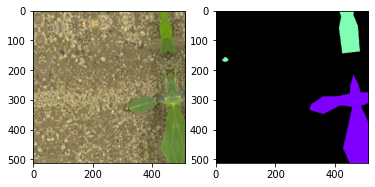

In [40]:
fig, ax = plt.subplots(1, 2)

augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

# Model setup

## Models

### Bonnet

In [41]:
# ------------------------
# Bonnet convolution layer
# ------------------------
def ConvolutionLayer(input, filters, kernel_size, strides, padding, batch_norm = False):

  conv = tf.keras.layers.Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, kernel_initializer = 'he_uniform')(input)
  if batch_norm:
    bn = tf.keras.layers.BatchNormalization(momentum=0.9)(conv)
  else:
    bn = conv
  out = tf.keras.layers.ELU()(bn)
  
  return out

In [42]:
# ---------------------
# Bonnet residual block
# ---------------------
def ResidualBlock(input):
  
  conv1 = ConvolutionLayer(input = input, filters = 8, kernel_size = (1, 1), strides = (1, 1), padding = 'same')
  conv2 = ConvolutionLayer(input = conv1, filters = 8, kernel_size = (5, 1), strides = (1, 1), padding = 'same')
  conv3 = ConvolutionLayer(input = conv2, filters = 8, kernel_size = (1, 5), strides = (1, 1), padding = 'same')
  conv4 = ConvolutionLayer(input = conv3, filters = 16, kernel_size = (1, 1), strides = (1, 1), padding = 'same')
  out = tf.keras.layers.Add()([conv4, input])

  return out

In [43]:
def define_bonnet(input_size = (384, 512, 3)):

  inputs = tf.keras.Input(input_size)

  conv = ConvolutionLayer(input = inputs, filters = 16, kernel_size = (5, 5), strides = (1, 1), padding = 'same', batch_norm = True)

  # -------
  # Encoder
  # -------
  '''
  # Added
  conv = ResidualBlock(conv)
  conv = ResidualBlock(conv)
  conv = ResidualBlock(conv)
  conv = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2))(conv)

  # Added
  conv = ResidualBlock(conv)
  conv = ResidualBlock(conv)
  conv = ResidualBlock(conv)
  conv = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2))(conv)
  '''

  # Residual block 1
  residual1 = ResidualBlock(conv)

  # Residual block 2
  residual2 = ResidualBlock(residual1)

  # Residual block 3
  residual3 = ResidualBlock(residual2)

  # Pooling 1
  pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2))(residual3)

  # Residual block 4
  residual4 = ResidualBlock(pool1)

  # Residual block 5
  residual5 = ResidualBlock(residual4)

  # Residual block 6
  residual6 = ResidualBlock(residual5)

  # Pooling 2
  pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2))(residual6)

  # Residual block 7
  residual7 = ResidualBlock(pool2)

  # Residual block 8
  residual8 = ResidualBlock(residual7)

  # Residual block 9
  residual9 = ResidualBlock(residual8)

  # Pooling 3
  pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2))(residual9)

  # Residual block 10
  residual10 = ResidualBlock(pool3)

  # Residual block 11
  residual11 = ResidualBlock(residual10)

  # Residual block 12
  residual12 = ResidualBlock(residual11)

  # Pooling 4
  pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2))(residual11)

  # -------

  # -------
  # Decoder
  # -------

  # Unpooling with shared indexes
  unpool1 = tf.keras.layers.UpSampling2D()(pool4)

  # Residual block 13
  residual13 = ResidualBlock(unpool1)

  # Residual block 14
  residual14 = ResidualBlock(residual13)

  # Residual block 15
  residual15 = ResidualBlock(residual14)

  # Unpooling with shared indexes
  unpool2 = tf.keras.layers.UpSampling2D()(residual15)

  # Residual block 16
  residual16 = ResidualBlock(unpool2)

  # Residual block 17
  residual17 = ResidualBlock(residual16)

  # Residual block 18
  residual18 = ResidualBlock(residual17)

  # Unpooling with shared indexes
  unpool3 = tf.keras.layers.UpSampling2D()(residual18)

  # Residual block 19
  residual19 = ResidualBlock(unpool3)

  # Residual block 20
  residual20 = ResidualBlock(residual19)

  # Residual block 21
  residual21 = ResidualBlock(residual20)

  # Unpooling with shared indexes
  unpool4 = tf.keras.layers.UpSampling2D()(residual21)

  # Residual block 22
  residual22 = ResidualBlock(unpool4)

  # Residual block 23
  residual23 = ResidualBlock(residual22)

  # Residual block 24
  residual24 = ResidualBlock(residual23)
  '''
  # ADDED
  residual24 = ResidualBlock(residual24)
  residual24 = ResidualBlock(residual24)
  residual24 = ResidualBlock(residual24)
  residual24 = tf.keras.layers.UpSampling2D()(residual24)

  # ADDED
  residual24 = ResidualBlock(residual24)
  residual24 = ResidualBlock(residual24)
  residual24 = ResidualBlock(residual24)
  residual24 = tf.keras.layers.UpSampling2D()(residual24)
  '''
  # CONV(1,1) with 3 kernels
  out = tf.keras.layers.Conv2D(filters = 3, # only 1 output neuron since the classification is binary: output => 0 == background, 1 == object
                               kernel_size = (1, 1), # => FC layer convolutionalized
                               strides = (1, 1), # stride of a FC layer
                               padding = 'same', # or same: kernel is (1,1) and stride (1,1) so is not important
                               activation='softmax')(residual24)

  model = tf.keras.Model(inputs = inputs, outputs = out)

  # Visualize created model as a table
  model.summary()

  return model

### Resnet50-Unet

In [44]:
import keras
from keras.models import *
from keras.layers import *
from keras import layers
import keras.backend as K

IMAGE_ORDERING = 'channels_last'


if IMAGE_ORDERING == 'channels_first':
    pretrained_url = "https://github.com/fchollet/deep-learning-models/" \
                     "releases/download/v0.2/" \
                     "resnet50_weights_th_dim_ordering_th_kernels_notop.h5"
elif IMAGE_ORDERING == 'channels_last':
    pretrained_url = "https://github.com/fchollet/deep-learning-models/" \
                     "releases/download/v0.2/" \
                     "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

if IMAGE_ORDERING == 'channels_first':
    MERGE_AXIS = 1
elif IMAGE_ORDERING == 'channels_last':
    MERGE_AXIS = -1

def one_side_pad(x):
    x = ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING)(x)
    if IMAGE_ORDERING == 'channels_first':
        x = Lambda(lambda x: x[:, :, :-1, :-1])(x)
    elif IMAGE_ORDERING == 'channels_last':
        x = Lambda(lambda x: x[:, :-1, :-1, :])(x)
    return x


def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at
                     main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters

    if IMAGE_ORDERING == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), data_format=IMAGE_ORDERING,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, data_format=IMAGE_ORDERING,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), data_format=IMAGE_ORDERING,
               name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block,
               strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at
                     main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with
    strides=(2,2) and the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters

    if IMAGE_ORDERING == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), data_format=IMAGE_ORDERING, strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, data_format=IMAGE_ORDERING,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), data_format=IMAGE_ORDERING,
               name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), data_format=IMAGE_ORDERING,
                      strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

def get_resnet50_encoder(input_height=224,  input_width=224,
                         pretrained='imagenet',
                         include_top=True, weights='imagenet',
                         input_tensor=None, input_shape=None,
                         pooling=None,
                         classes=1000):

    assert input_height % 32 == 0
    assert input_width % 32 == 0

    if IMAGE_ORDERING == 'channels_first':
        img_input = Input(shape=(3, input_height, input_width))
    elif IMAGE_ORDERING == 'channels_last':
        img_input = Input(shape=(input_height, input_width, 3))

    if IMAGE_ORDERING == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3), data_format=IMAGE_ORDERING)(img_input)
    x = Conv2D(64, (7, 7), data_format=IMAGE_ORDERING,
               strides=(2, 2), name='conv1')(x)
    f1 = x

    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), data_format=IMAGE_ORDERING, strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    f2 = one_side_pad(x)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    f3 = x

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')
    f4 = x

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    f5 = x

    x = AveragePooling2D(
        (7, 7), data_format=IMAGE_ORDERING, name='avg_pool')(x)
    # f6 = x
    
    if pretrained == 'imagenet':
        weights_path = keras.utils.get_file(
            pretrained_url.split("/")[-1], pretrained_url)
        Model(img_input, x).load_weights(weights_path)
    
    return img_input, [f1, f2, f3, f4, f5]

def get_segmentation_model(input, output):

    img_input = input
    o = output

    o_shape = Model(img_input, o).output_shape
    i_shape = Model(img_input, o).input_shape

    if IMAGE_ORDERING == 'channels_first':
        output_height = o_shape[2]
        output_width = o_shape[3]
        input_height = i_shape[2]
        input_width = i_shape[3]
        n_classes = o_shape[1]
        o = (Reshape((-1, output_height*output_width)))(o)
        o = (Permute((2, 1)))(o)
    elif IMAGE_ORDERING == 'channels_last':
        output_height = o_shape[1]
        output_width = o_shape[2]
        input_height = i_shape[1]
        input_width = i_shape[2]
        n_classes = o_shape[3]
        o = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="nearest")(o)
        #o = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="nearest")(o)
    o = (Activation('softmax'))(o)
    model = Model(img_input, o)
    model.output_width = output_width
    model.output_height = output_height
    model.n_classes = n_classes
    model.input_height = input_height
    model.input_width = input_width
    model.model_name = ""
    return model

def _unet(n_classes, encoder, l1_skip_conn=True, input_height=416,
          input_width=608):

    img_input, levels = encoder(
        input_height=input_height, input_width=input_width)
    [f1, f2, f3, f4, f5] = levels

    o = f4

    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(512, (3, 3), padding='valid' , activation='relu' , data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
    o = (concatenate([o, f3], axis=MERGE_AXIS))
    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(256, (3, 3), padding='valid', activation='relu' , data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
    o = (concatenate([o, f2], axis=MERGE_AXIS))
    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(128, (3, 3), padding='valid' , activation='relu' , data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)

    if l1_skip_conn:
        o = (concatenate([o, f1], axis=MERGE_AXIS))

    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(64, (3, 3), padding='valid', activation='relu', data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = Conv2D(n_classes, (3, 3), padding='same',
               data_format=IMAGE_ORDERING)(o)

    model = get_segmentation_model(img_input, o)

    return model

def resnet50_unet(n_classes, input_height=416, input_width=608,
                  encoder_level=3):

    model = _unet(n_classes, get_resnet50_encoder,
                  input_height=input_height, input_width=input_width)
    model.model_name = "resnet50_unet"
    return model

### EfficientB7-Unet

In [45]:
def Efficient_Unet(input_shape = (896, 1280, 3)):
  efficient = tf.keras.applications.EfficientNetB7(weights='imagenet', include_top=False, input_shape = input_shape)
  
  # We only use: 
  # efficient.layers[:-3]
  
  input = efficient.input

  out_eff = efficient.get_layer('block7d_add').output

  # Up.Conv
  # -------
  skip_unpoolb7 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(out_eff)
  
  convb7 = tf.keras.layers.Conv2D(filters = 512, kernel_size=(3, 3), padding = 'same')(skip_unpoolb7)
  # -------

  # Concat b6
  # -------
  skip_unpoolb6 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(efficient.get_layer('block6m_add').output)

  concatb6 = tf.keras.layers.Concatenate()([skip_unpoolb6, convb7])
  # -------

  # Conv + Upsampling
  # -------
  conv2 = tf.keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same')(concatb6)
  
  unpool2 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(conv2)
  # -------


  # Concat b4
  # ---------
  skip_unpoolb4 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(efficient.get_layer('block4g_add').output)

  concatb4 = tf.keras.layers.Concatenate()([skip_unpoolb4, unpool2])
  # ---------

  # Conv + Upsampling
  # -----------------
  conv3 = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same')(concatb4)
  
  unpool3 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(conv3)
  # ----------------- 
  
  # Concat b3
  # ---------
  skip_unpoolb3 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(efficient.get_layer('block3g_add').output)

  concatb3 = tf.keras.layers.Concatenate()([skip_unpoolb3, unpool3])
  # ---------
  
  # Conv + Upsampling
  # -----------------
  conv4 = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same')(concatb3)
  
  unpool4 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(conv4)
  # ----------------- 

  # Concat b2
  # ---------
  skip_unpoolb2 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(efficient.get_layer('block2g_add').output)

  concatb2 = tf.keras.layers.Concatenate()([skip_unpoolb2, unpool4])
  # ---------

  # Conv + Upsampling
  # -----------------
  conv5 = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same')(concatb2)
  
  unpool5 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(conv5)
  # ----------------- 

  output = tf.keras.layers.Conv2D(filters = 3, kernel_size= (1, 1), strides = (1, 1), activation = 'softmax')(unpool5)

  model = tf.keras.Model(inputs = input, outputs = output)
  
  model.summary()

  return model

## Losses

In [46]:
# ------------------------------------
# Utility functions for loss functions
# ------------------------------------

import keras.backend as backend

def _gather_channels(x, indexes):
  """Slice tensor along channels axis by given indexes"""
    
  x = backend.permute_dimensions(x, (3, 0, 1, 2))
  x = backend.gather(x, indexes)
  x = backend.permute_dimensions(x, (1, 2, 3, 0))

def get_reduce_axes(per_image):
    
    axes = [1, 2]
    if not per_image:
        axes.insert(0, 0)
    return axes


def gather_channels(*xs, indexes=None):
    """Slice tensors along channels axis by given indexes"""
    if indexes is None:
        return xs
    elif isinstance(indexes, (int)):
        indexes = [indexes]
    xs = [_gather_channels(x, indexes=indexes) for x in xs]
    return xs


def round_if_needed(x, threshold):
    
    if threshold is not None:
        x = backend.greater(x, threshold)
        x = backend.cast(x, backend.floatx())
    return x

def average(x, per_image=False, class_weights=None):

    if per_image:
        x = backend.mean(x, axis=0)
    if class_weights is not None:
        x = x * class_weights
    return backend.mean(x)

In [47]:
# ----------------
# Dice coefficient
# ----------------
def f_score(gt, pr, beta=1, class_weights=1, class_indexes=None, smooth=1e-7, per_image=False, threshold=None):
    """The F-score (Dice coefficient) can be interpreted as a weighted average of the precision and recall,
    where an F-score reaches its best value at 1 and worst score at 0.
    The relative contribution of ``precision`` and ``recall`` to the F1-score are equal.
    The formula for the F score is:
    .. math:: F_\beta(precision, recall) = (1 + \beta^2) \frac{precision \cdot recall}
        {\beta^2 \cdot precision + recall}
    The formula in terms of *Type I* and *Type II* errors:
    .. math:: F_\beta(A, B) = \frac{(1 + \beta^2) TP} {(1 + \beta^2) TP + \beta^2 FN + FP}
    where:
        TP - true positive;
        FP - false positive;
        FN - false negative;
    Args:
        gt: ground truth 4D keras tensor (B, H, W, C) or (B, C, H, W)
        pr: prediction 4D keras tensor (B, H, W, C) or (B, C, H, W)
        class_weights: 1. or list of class weights, len(weights) = C
        class_indexes: Optional integer or list of integers, classes to consider, if ``None`` all classes are used.
        beta: f-score coefficient
        smooth: value to avoid division by zero
        per_image: if ``True``, metric is calculated as mean over images in batch (B),
            else over whole batch
        threshold: value to round predictions (use ``>`` comparison), if ``None`` prediction will not be round
    Returns:
        F-score in range [0, 1]
    """

    gt, pr = gather_channels(gt, pr, indexes=class_indexes)
    pr = round_if_needed(pr, threshold)
    axes = get_reduce_axes(per_image)

    # calculate score
    tp = backend.sum(gt * pr, axis=axes)
    fp = backend.sum(pr, axis=axes) - tp
    fn = backend.sum(gt, axis=axes) - tp

    score = ((1 + beta ** 2) * tp + smooth) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)
    score = average(score, per_image, class_weights)

    return score

In [48]:
# ---------
# Dice loss
# ---------
def DiceLoss(y_true, y_pred):
    """Creates a criterion to measure Dice loss:
    .. math:: L(precision, recall) = 1 - (1 + \beta^2) \frac{precision \cdot recall}
        {\beta^2 \cdot precision + recall}
    The formula in terms of *Type I* and *Type II* errors:
    .. math:: L(tp, fp, fn) = \frac{(1 + \beta^2) \cdot tp} {(1 + \beta^2) \cdot fp + \beta^2 \cdot fn + fp}
    where:
         - tp - true positives;
         - fp - false positives;
         - fn - false negatives;
    Args:
        beta: Float or integer coefficient for precision and recall balance.
        class_weights: Array (``np.array``) of class weights (``len(weights) = num_classes``).
        class_indexes: Optional integer or list of integers, classes to consider, if ``None`` all classes are used.
        per_image: If ``True`` loss is calculated for each image in batch and then averaged,
        else loss is calculated for the whole batch.
        smooth: Value to avoid division by zero.
    Returns:
        A callable ``dice_loss`` instance. Can be used in ``model.compile(...)`` function`
        or combined with other losses.
    Example:
    .. code:: python
        loss = DiceLoss()
        model.compile('SGD', loss=loss)
    """
    return 1 - f_score(
                        y_true,
                        y_pred,
                        beta=1,
                        class_weights=1,
                        class_indexes=None,
                        smooth=1e-7,
                        per_image=False,
                        threshold=None
                    )

In [49]:
# ----------------------------------------
# Focal loss for multiclass classification
# ----------------------------------------
def categorical_focal_loss(gt, pr, gamma=2.0, alpha=0.25, class_indexes=None):
    """Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = - gt * alpha * ((1 - pr)^gamma) * log(pr)
    Args:
        gt: ground truth 4D keras tensor (B, H, W, C) or (B, C, H, W)
        pr: prediction 4D keras tensor (B, H, W, C) or (B, C, H, W)
        alpha: the same as weighting factor in balanced cross entropy, default 0.25
        gamma: focusing parameter for modulating factor (1-p), default 2.0
        class_indexes: Optional integer or list of integers, classes to consider, if ``None`` all classes are used.
    """

    gt, pr = gather_channels(gt, pr, indexes=class_indexes)

    # clip to prevent NaN's and Inf's
    pr = backend.clip(pr, backend.epsilon(), 1.0 - backend.epsilon())

    # Calculate focal loss
    loss = - gt * (alpha * backend.pow((1 - pr), gamma) * backend.log(pr))

    return backend.mean(loss)

In [50]:
# ----------------------------------------
# Focal loss for multiclass classification
# ----------------------------------------
def CategoricalFocalLoss(y_true, y_pred):
    """Creates a criterion that measures the Categorical Focal Loss between the
    ground truth (gt) and the prediction (pr).
    .. math:: L(gt, pr) = - gt \cdot \alpha \cdot (1 - pr)^\gamma \cdot \log(pr)
    Args:
        alpha: Float or integer, the same as weighting factor in balanced cross entropy, default 0.25.
        gamma: Float or integer, focusing parameter for modulating factor (1 - p), default 2.0.
        class_indexes: Optional integer or list of integers, classes to consider, if ``None`` all classes are used.
    Returns:
        A callable ``categorical_focal_loss`` instance. Can be used in ``model.compile(...)`` function
        or combined with other losses.
    Example:
        .. code:: python
            loss = CategoricalFocalLoss()
            model.compile('SGD', loss=loss)
    """
    return categorical_focal_loss(
                                  y_true,
                                  y_pred,
                                  alpha=0.25,
                                  gamma=2.,
                                  class_indexes=None
                                 )

In [51]:
# -------------------------------------------------------------------
# Combined loss: Focal loss for multiclass classification + Dice loss
# -------------------------------------------------------------------
def CombinedLoss(y_true, y_pred):
  return categorical_focal_loss(y_true, y_pred, alpha=0.25, gamma=2., class_indexes=None) + 1 - f_score(y_true, y_pred, beta=1, class_weights=np.array([0.25, 1., 1.]), class_indexes=None, smooth=1e-7, per_image=False, threshold=None)

In [52]:
# ----------------------------
# IoU metric for loss function
# ----------------------------
def iou_score(gt, pr, class_weights=1., class_indexes=None, smooth=1e-7, per_image=False, threshold=None):
    """ The `Jaccard index`_, also known as Intersection over Union and the Jaccard similarity coefficient
    (originally coined coefficient de communauté by Paul Jaccard), is a statistic used for comparing the
    similarity and diversity of sample sets. The Jaccard coefficient measures similarity between finite sample sets,
    and is defined as the size of the intersection divided by the size of the union of the sample sets:
    .. math:: J(A, B) = \frac{A \cap B}{A \cup B}
    Args:
        gt: ground truth 4D keras tensor (B, H, W, C) or (B, C, H, W)
        pr: prediction 4D keras tensor (B, H, W, C) or (B, C, H, W)
        class_weights: 1. or list of class weights, len(weights) = C
        class_indexes: Optional integer or list of integers, classes to consider, if ``None`` all classes are used.
        smooth: value to avoid division by zero
        per_image: if ``True``, metric is calculated as mean over images in batch (B),
            else over whole batch
        threshold: value to round predictions (use ``>`` comparison), if ``None`` prediction will not be round
    Returns:
        IoU/Jaccard score in range [0, 1]
    .. _`Jaccard index`: https://en.wikipedia.org/wiki/Jaccard_index
    """

    gt, pr = gather_channels(gt, pr, indexes=class_indexes)
    pr = round_if_needed(pr, threshold)
    axes = get_reduce_axes(per_image)

    # score calculation
    intersection = backend.sum(gt * pr, axis=axes)
    union = backend.sum(gt + pr, axis=axes) - intersection

    score = (intersection + smooth) / (union + smooth)
    score = average(score, per_image, class_weights)

    return score

In [53]:
# --------------------
# Logarithmic IoU loss
# --------------------
def IoU_loss(y_true, y_pred):
  return - backend.log(iou_score(y_true, y_pred, class_weights=np.array([0.25, 1., 1.]), class_indexes=None, smooth=1e-7, per_image=False, threshold=None))

## Setup functions

In [54]:
# -------------------------------------------------
# Define transfer learning model for Efficient-Unet
# -------------------------------------------------

def define_transfer_learning(input_size = (896, 1280, 3)):

  eff_unet_model = Efficient_Unet(input_shape = input_size)
  
  eff_unet_model.trainable = True

  train = False
  for layer in eff_unet_model.layers:
    if train:
      layer.trainable = True
    else:
      layer.trainable = False
    if layer.name == 'block7d_add':
      train = True

  model = tf.keras.Sequential()
  
  model.add(eff_unet_model)

  #eff_unet_model.summary()
  model.summary()

  return model

In [55]:
# -------------------------------------------
# Define fine tuning model for Efficient-Unet
# -------------------------------------------
def define_fine_tuning(input_size = (896, 1280, 3)):

  eff_unet_model = Efficient_Unet(input_shape = input_size)

  eff_unet_model.trainable = True

  train = False

  for layer in eff_unet_model.layers:
  
    if train:
      layer.trainable = True
    else:
      layer.trainable = False
    
    if layer.name == 'block7d_add':
      train = True

    #if ("block4" in layer.name):
    #  layer.trainable = True
    
    #if ("block5" in layer.name):
    #  layer.trainable = True

    if ("block6" in layer.name):
      layer.trainable = True
    
    if ("block7" in layer.name):
      layer.trainable = True

    if "_bn" in layer.name:
      layer.trainable = False

    # Print the layer of the EfficientNet-B7 and if they are set to trainable
    print(str(layer.name) + ' '*(35 - len(str(layer.name))) + '----> Trainable: ' + str(layer.trainable))

  model = tf.keras.Sequential()
  
  model.add(eff_unet_model)

  model.summary()

  return model

In [56]:
# --------------
# meanIoU metric
# --------------
def meanIoU(y_true, y_pred):

  # get predicted class from softmax
  y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

  per_class_iou = []

  for i in range(1,3): # exclude the background class 0

    # Get prediction and target related to only a single class (i)
    class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
    class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
    intersection = tf.reduce_sum(class_true * class_pred)
    union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
    iou = (intersection + 1e-7) / (union + 1e-7)
    per_class_iou.append(iou)

  return tf.reduce_mean(per_class_iou)

In [57]:
# -----------------
# Compile the model
# -----------------
def compile_model(model, lr):

  # Optimization params
  # -------------------

  # Loss
  # ----
  # Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
  diceloss = DiceLoss 
  sparseloss = tf.keras.losses.SparseCategoricalCrossentropy()
  catfocalloss = CategoricalFocalLoss
  iouloss = IoU_loss
  combinedloss = CombinedLoss

  loss = sparseloss
  # ----

  # Optimization function
  # ---------------------
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr) #tfa.optimizers.RectifiedAdam(learning_rate=lr) 
  # ---------------------

  # Validation metrics
  # ------------------
  mIoU = meanIoU
  metrics = ['accuracy', mIoU]
  # ------------------

  # Compile Model
  # -------------
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights = [1.5133127348818056, 14.139274748955497, 20.349217406952828])
  # -------------

  # -------------------
  
  return model

In [58]:
# -----------------
# Set the callbacks
# -----------------
def set_callbacks(type, model_checkpoint, visualize_tensorboard, early_stop, reduce_lr_on_plateau):
  
  import os
  from datetime import datetime

  cwd = os.getcwd()

  exps_dir = os.path.join('/content/drive/My Drive/Challenge_2/', 'segmentation_experiments')
  if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

  model_name = type

  exp_dir = os.path.join(exps_dir, model_name)
  if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
  callbacks = []

  # Model checkpoint
  # ----------------
  if model_checkpoint:
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'),
                                                       monitor='val_loss', 
                                                       save_weights_only = True, # False to save the model directly
                                                       save_best_only = True)  
    callbacks.append(ckpt_callback)
  # ----------------

  # Visualize Learning on Tensorboard
  # ---------------------------------
  if visualize_tensorboard:
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
    
    # By default shows losses and metrics for both training and validation
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                                 profile_batch=0,
                                                 histogram_freq=1)  # if 1 shows weights histograms
    callbacks.append(tb_callback)
  # ---------------------------------

  # Early Stopping
  # --------------
  if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                   patience = 15,
                                                   restore_best_weights=True)
    callbacks.append(es_callback)
  # --------------

  # Reduce Learning rate on plateau
  # -------------------------------
  if reduce_lr_on_plateau:
    rlr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                        factor=0.1, 
                                                        patience=1, 
                                                        verbose=1, 
                                                        mode='auto', 
                                                        min_delta=0.0001)
    callbacks.append(rlr_callback)
  # -------------------------------

  return callbacks

In [59]:
# -----------
# Train model
# -----------
def train_model(model, train_dataset, dataset, valid_dataset, dataset_valid, callbacks, num_epochs, bs):
  
  history_model = model.fit(x = train_dataset,
                            epochs = num_epochs,  #### set repeat in training dataset
                            steps_per_epoch = int(np.ceil(len(dataset) / bs)),
                            validation_data = valid_dataset,
                            validation_steps = int(np.ceil(len(dataset_valid) / bs)), 
                            callbacks = callbacks)
  
  return history_model

# Training functions

In [60]:
# ------------------
# Train Bonnet model
# ------------------
def train_bonnet():
  
  apply_data_augmentation = True

  img_h = 512
  img_w = 512

  num_classes = 3

  bs = 24

  lr = 5e-5

  num_epochs = 50

  model_checkpoint = True
  visualize_tensorboard = False
  early_stop = False
  reduce_lr_on_plateau = True

  print('--------------------------------------------')
  print('Image heigth                      ---> ' + str(img_h))
  print('Image width                       ---> ' + str(img_w))
  print('Batch size                        ---> ' + str(bs))
  print('Learning rate                     ---> ' + str(lr))
  print('Number of epochs                  ---> ' + str(num_epochs))
  print('Model checkpoint                  ---> ' + str(model_checkpoint))
  print('Visualize tensorboars             ---> ' + str(visualize_tensorboard))
  print('Early stopping                    ---> ' + str(early_stop))
  print('Reduce learning rate on plateau   ---> ' + str(reduce_lr_on_plateau))
  print('--------------------------------------------')

  [img_data_gen, mask_data_gen] = data_generator(apply_data_augmentation)

  [train_dataset, dataset, valid_dataset, dataset_valid] = create_dataset(img_data_gen, mask_data_gen, img_h = img_h, img_w = img_w, bs = bs, num_classes = num_classes)

  model = define_bonnet(input_size = (img_h, img_w, 3))
  
  model = compile_model(model, lr = lr)

  callbacks = set_callbacks('bonnet', model_checkpoint = model_checkpoint, visualize_tensorboard = visualize_tensorboard, early_stop = early_stop, reduce_lr_on_plateau = reduce_lr_on_plateau)

  history = train_model(model, train_dataset, dataset, valid_dataset, dataset_valid, callbacks, num_epochs = num_epochs, bs = bs)

  plot_history(history)

  return model, history

In [61]:
# -----------------------------------------------
# Train the Efficient-Unet with transfer learning
# -----------------------------------------------
def train_transfer_learning():
  
  apply_data_augmentation = True

  img_h = int(512)
  img_w = int(512)

  num_classes = 3

  bs = 16

  lr = 5e-5

  num_epochs = 100

  model_checkpoint = True
  visualize_tensorboard = False
  early_stop = False
  reduce_lr_on_plateau = True

  print('--------------------------------------------')
  print('Image heigth                      ---> ' + str(img_h))
  print('Image width                       ---> ' + str(img_w))
  print('Batch size                        ---> ' + str(bs))
  print('Learning rate                     ---> ' + str(lr))
  print('Number of epochs                  ---> ' + str(num_epochs))
  print('Model checkpoint                  ---> ' + str(model_checkpoint))
  print('Visualize tensorboars             ---> ' + str(visualize_tensorboard))
  print('Early stopping                    ---> ' + str(early_stop))
  print('Reduce learning rate on plateau   ---> ' + str(reduce_lr_on_plateau))
  print('--------------------------------------------')

  [img_data_gen, mask_data_gen] = data_generator(apply_data_augmentation)

  [train_dataset, dataset, valid_dataset, dataset_valid] = create_dataset(img_data_gen, mask_data_gen, img_h = img_h, img_w = img_w, bs = bs, num_classes = num_classes)

  model = define_transfer_learning(input_size = (img_h, img_w, 3))
  
  model = compile_model(model, lr = lr)

  callbacks = set_callbacks('eff-Unet_transfer_learning', model_checkpoint = model_checkpoint, visualize_tensorboard = visualize_tensorboard, early_stop = early_stop, reduce_lr_on_plateau = reduce_lr_on_plateau)

  history = train_model(model, train_dataset, dataset, valid_dataset, dataset_valid, callbacks, num_epochs = num_epochs, bs = bs)

  plot_history(history)

  return model, history

In [62]:
# -----------------------------------------
# Train the Efficient-Unet with fine tuning
# -----------------------------------------
def train_fine_tuning():
  
  apply_data_augmentation = True

  img_h = 512 #int(672)
  img_w = 512 #int(960)

  num_classes = 3

  bs = 16

  lr = 5e-5

  num_epochs = 50

  model_checkpoint = True
  visualize_tensorboard = False
  early_stop = False
  reduce_lr_on_plateau = True

  print('--------------------------------------------')
  print('Image heigth                      ---> ' + str(img_h))
  print('Image width                       ---> ' + str(img_w))
  print('Batch size                        ---> ' + str(bs))
  print('Learning rate                     ---> ' + str(lr))
  print('Number of epochs                  ---> ' + str(num_epochs))
  print('Model checkpoint                  ---> ' + str(model_checkpoint))
  print('Visualize tensorboars             ---> ' + str(visualize_tensorboard))
  print('Early stopping                    ---> ' + str(early_stop))
  print('Reduce learning rate on plateau   ---> ' + str(reduce_lr_on_plateau))
  print('--------------------------------------------')

  [img_data_gen, mask_data_gen] = data_generator(apply_data_augmentation)

  [train_dataset, dataset, valid_dataset, dataset_valid] = create_dataset(img_data_gen, mask_data_gen, img_h = img_h, img_w = img_w, bs = bs, num_classes = num_classes)

  model = define_fine_tuning(input_size = (img_h, img_w, 3))
  
  model = compile_model(model, lr = lr)

  callbacks = set_callbacks('eff-Unet_fine_tuning_PATCH_512x512_STRIDE_1_SparseWeightedLoss', model_checkpoint = model_checkpoint, visualize_tensorboard = visualize_tensorboard, early_stop = early_stop, reduce_lr_on_plateau = reduce_lr_on_plateau)

  history = train_model(model, train_dataset, dataset, valid_dataset, dataset_valid, callbacks, num_epochs = num_epochs, bs = bs)

  plot_history(history)

  return model, history

# Plots

In [63]:
# ----------------------------------------------------------------------------------------------------
# Plot the history of the trained model (loss, val_loss; accuracy, val_accuracy; meanIoU, val_meanIoU)
# ----------------------------------------------------------------------------------------------------
def plot_history(history):
  from matplotlib import pyplot

  pyplot.figure()
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='validation')
  pyplot.legend()
  pyplot.show()

  pyplot.figure()
  pyplot.plot(history.history['accuracy'], label='train')
  pyplot.plot(history.history['val_accuracy'], label='validation')
  pyplot.legend()
  pyplot.show()

  pyplot.figure()
  pyplot.plot(history.history['meanIoU'], label='train')
  pyplot.plot(history.history['val_meanIoU'], label='validation')
  pyplot.legend()
  pyplot.show() 

# Execution

In [ ]:
[model, history] = train_fine_tuning() # fine tuning of EFF-Unet (blocks 6 and 7) on all the dataset, using tiles of 512x512 and stride 512x512

--------------------------------------------
Image heigth                      ---> 512
Image width                       ---> 512
Batch size                        ---> 16
Learning rate                     ---> 5e-05
Number of epochs                  ---> 50
Model checkpoint                  ---> True
Visualize tensorboars             ---> False
Early stopping                    ---> False
Reduce learning rate on plateau   ---> True
--------------------------------------------
258080768/258076736 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 

# Predictions from the network

In [ ]:
apply_data_augmentation = True

img_h = int(512)
img_w = int(512)

num_classes = 3

bs = 1

[img_data_gen, mask_data_gen] = data_generator(apply_data_augmentation)

[train_dataset, dataset, valid_dataset, dataset_valid] = create_dataset(img_data_gen, mask_data_gen, img_h = img_h, img_w = img_w, bs = bs, num_classes = num_classes)

model = define_transfer_learning(input_size = (img_h, img_w, 3))

exps_dir = os.path.join('/content/drive/My Drive/Challenge_2/', 'segmentation_experiments')
model_name = 'eff-Unet_fine_tuning_PATCH_512x512_STRIDE_1_SparseWeightedLoss' 
exp_dir = os.path.join(exps_dir, model_name)
ckpt_dir = os.path.join(exp_dir, 'ckpts')
latest = tf.train.latest_checkpoint(ckpt_dir)
print(latest)

model.load_weights(latest)

In [ ]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

iterator = iter(valid_dataset)

In [ ]:
image, target = next(iterator)

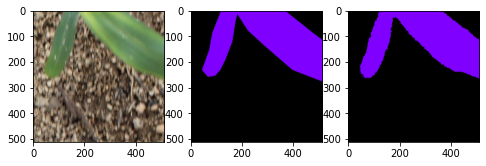

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()

image = image[0]
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
predicted_class = tf.argmax(out_sigmoid, -1)

#out_sigmoid.shape
#print(tf.argmax(out_sigmoid, -1).shape)

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, 3):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image)) # 1st: Image
ax[1].imshow(np.uint8(target_img)) # 2nd: Target mask
ax[2].imshow(np.uint8(prediction_img)) #3rd: Predicted mask

fig.canvas.draw()
time.sleep(1)

# Create prediction.json

In [ ]:
if SPLIT_DATASET == False:
  ! unzip '/content/drive/My Drive/Challenge_2/Development_Dataset.zip'

In [ ]:
def rle_encode(img):
  '''
  img: numpy array, 1 - foreground, 0 - background
  Returns run length as string formatted
  '''
  pixels = img.flatten()
  pixels = np.concatenate([[0], pixels, [0]])
  runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
  runs[1::2] -= runs[::2]
  
  return ' '.join(str(x) for x in runs)

In [ ]:
import json


# The submission file will be a zip file containing the a
# submission.json file.

# It must have the following structure:

# - image name (without any extension, e.g., png, jpg, etc.)
#   - shape: shape of the original image as list [Height, Width]
#   - team: team of the original image. One in {'Bipbip', 'Pead', 'Roseau', 'Weedelec'}
#   - crop: crop of the original image. One in {'Haricot', 'Mais'}
#   - segmentation: prediction (as a dict)
#     - crop: RLE encoded crop segmentation (no weed)
#     - weed: RLE encoded weed segmentation (no crop)

# Please refer to the folder structure of the given dataset to fill
# the team and crop keys.

if USE_TILING == True:

  teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
  plants = ['Haricot', 'Mais']

  submission_dict = {}

  patch_height = 512
  patch_width = 512
  h_stride = 0.25
  w_stride = 0.25

  for t in teams:
    for p in plants:

      tmp_path = '/content/Test_Final/' + t + '/' + p + '/' + 'Images'
      
      image_filenames = os.listdir(tmp_path)

      for img_name in image_filenames:
        
        tmp_path = '/content/Test_Final/' + t + '/' + p + '/' + 'Images'
        tmp_path = os.path.join(tmp_path, img_name)
        img = Image.open(tmp_path).convert('RGB')
        
        img_name = img_name.split('.')[0]

        submission_dict[img_name] = {}
        submission_dict[img_name]['shape'] = [img.height, img.width]
        submission_dict[img_name]['team'] = t
        submission_dict[img_name]['crop'] = p
        submission_dict[img_name]['segmentation'] = {}

        # Resize image for the network
        w, h = img.size

        # Getting the np array with the batch dimension
        img_array = np.array(img)
        
        # Tiling
        patches, image_dict = create_patches(img_array, patch_height=patch_height, patch_width=patch_width, h_stride=h_stride, w_stride=w_stride)

        patches_predict = []

        for i in range(len(patches)):
          
          patch_array = patches[i]

          patch_array = np.expand_dims(patch_array, 0) # insert batch dimension

          # Prediction from the model
          out = model.predict(x = patch_array)

          #patch_array = np.reshape(patch_array, patch_array.shape[1:])
          out = out[0, ...]
          #print(out.shape)
          
          patches_predict.append(out)

        # Stitch patches into the imge prediction
        out = stitch_patch(patches = patches_predict, image_dict = image_dict, h_stride = h_stride, w_stride = w_stride, channel = 3)
        
        out = np.array(out)

        # Getting the numpy array with prediction
        mask_arr = tf.argmax(out, -1)
        mask_arr = mask_arr.numpy()
        #mask_arr = out
        
        # RLE encoding
        # crop
        rle_encoded_crop = rle_encode(mask_arr == 1)
        # weed
        rle_encoded_weed = rle_encode(mask_arr == 2)

        submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
        submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed
        

  # Finally, save the results into the submission.json file
  with open('/content/submission.json', 'w') as f:
    json.dump(submission_dict, f)

  ! mkdir '/content/drive/My Drive/Challenge_2/submission'
  ! rm '/content/drive/My Drive/Challenge_2/submission/submission.json'
  ! cp '/content/submission.json' '/content/drive/My Drive/Challenge_2/submission/submission.json'

In [ ]:
import json

# The submission file will be a zip file containing the a
# submission.json file.

# It must have the following structure:

# - image name (without any extension, e.g., png, jpg, etc.)
#   - shape: shape of the original image as list [Height, Width]
#   - team: team of the original image. One in {'Bipbip', 'Pead', 'Roseau', 'Weedelec'}
#   - crop: crop of the original image. One in {'Haricot', 'Mais'}
#   - segmentation: prediction (as a dict)
#     - crop: RLE encoded crop segmentation (no weed)
#     - weed: RLE encoded weed segmentation (no crop)

# Please refer to the folder structure of the given dataset to fill
# the team and crop keys.

if USE_TILING == False:

  teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
  plants = ['Haricot', 'Mais']

  submission_dict = {}

  for t in teams:
    for p in plants:

      tmp_path = '/content/Development_Dataset/Test_Dev/' + t + '/' + p + '/' + 'Images'
      
      image_filenames = os.listdir(tmp_path)

      for img_name in image_filenames:
        
        tmp_path = '/content/Development_Dataset/Test_Dev/' + t + '/' + p + '/' + 'Images'
        tmp_path = os.path.join(tmp_path, img_name)
        img = Image.open(tmp_path).convert('RGB')
        
        img_name = img_name.split('.')[0]

        submission_dict[img_name] = {}
        submission_dict[img_name]['shape'] = [img.height, img.width]
        submission_dict[img_name]['team'] = t
        submission_dict[img_name]['crop'] = p
        submission_dict[img_name]['segmentation'] = {}

        # Resize image for the network
        w, h = img.size

        img_h = int(896)
        img_w = int(1280)
        img = img.resize((img_w, img_h)) #size – The requested size in pixels, as a 2-tuple: (width, height). !!!!!!!!!!! ATTENTION !!!!!!!!! PIL function

        # Getting the np array with the batch dimension
        img_array = np.array(img)
        
        # Data Normalization
        #img_array = mask_image(img_array)

        img_array = np.expand_dims(img_array, 0) # insert batch dimension

        # Prediction from the model
        out = model.predict(x=img_array)
        
        # Resize of the output
        out = tf.image.resize(out, size=[h, w], method = 'nearest').numpy()

        # Getting the numpy array with prediction
        mask_arr = tf.argmax(out, -1)
        mask_arr = mask_arr.numpy()
        
        # RLE encoding
        # crop
        rle_encoded_crop = rle_encode(mask_arr == 1)
        # weed
        rle_encoded_weed = rle_encode(mask_arr == 2)

        submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
        submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed
        

  # Finally, save the results into the submission.json file
  with open('/content/submission.json', 'w') as f:
    json.dump(submission_dict, f)

  ! mkdir '/content/drive/My Drive/Challenge_2/submission'
  ! rm '/content/drive/My Drive/Challenge_2/submission/submission.json'
  ! cp '/content/submission.json' '/content/drive/My Drive/Challenge_2/submission/submission.json'

# Class weights

In [ ]:
def ENet_weighing(image_files, num_classes=4):
    '''
    The custom class weighing function as seen in the ENet paper.
    INPUTS:
    - image_files(list): a list of image_filenames which element can be read immediately
    OUTPUTS:
    - class_weights(list): a list of class weights where each index represents each class label and the element is the class weight for that label.
    '''
    #initialize dictionary with all 0
    label_to_frequency = {}
    for i in range(num_classes):
        label_to_frequency[i] = 0

    for n in range(len(image_files)):
        image = np.load(image_files[n])

        #For each label in each image, sum up the frequency of the label and add it to label_to_frequency dict
        for i in range(num_classes):
            class_mask = np.equal(image, i)
            class_mask = class_mask.astype(np.float32)
            class_frequency = np.sum(class_mask)

            label_to_frequency[i] += class_frequency

    #perform the weighing function label-wise and append the label's class weights to class_weights
    class_weights = []
    total_frequency = sum(label_to_frequency.values())
    for label, frequency in label_to_frequency.items():
        class_weight = 1 / np.log(1.02 + (frequency / total_frequency))
        class_weights.append(class_weight)

    #Set the last class_weight to 0.0
 #   class_weights[-1] = 0.0

    return class_weights

def median_frequency_balancing(image_files, num_classes=3):
    '''
    Perform median frequency balancing on the image files, given by the formula:
    f = Median_freq_c / total_freq_c
    where median_freq_c is the median frequency of the class for all pixels of C that appeared in images
    and total_freq_c is the total number of pixels of c in the total pixels of the images where c appeared.
    INPUTS:
    - image_files(list): a list of image_filenames which element can be read immediately
    - num_classes(int): the number of classes of pixels in all images
    OUTPUTS:
    - class_weights(list): a list of class weights where each index represents each class label and the element is the class weight for that label.
    '''
    # Initialize all the labels key with a list value
    label_to_frequency_dict = {}
    for i in range(num_classes):
        label_to_frequency_dict[i] = []

    for n in range(len(image_files)):
      image = np.load(image_files[n])

      #For each image sum up the frequency of each label in that image and append to the dictionary if frequency is positive.
      for i in range(num_classes):
        class_mask = np.equal(image, i)
        class_mask = class_mask.astype(np.float32)
        class_frequency = np.sum(class_mask)

        if class_frequency != 0.0:
            label_to_frequency_dict[i].append(class_frequency)

    class_weights = []

    #Get the total pixels to calculate total_frequency later
    total_pixels = 0
    for frequencies in label_to_frequency_dict.values():
        total_pixels += sum(frequencies)
    print('total_pixels=', total_pixels)
    for i, j in label_to_frequency_dict.items():
        j = sorted(j) #To obtain the median, we got to sort the frequencies

        median_frequency = np.median(j) / sum(j)
        total_frequency = sum(j) / total_pixels
        median_frequency_balanced = median_frequency / total_frequency
        class_weights.append(median_frequency_balanced)

    #Set the last class_weight to 0.0 as it's the background class
 #   class_weights[-1] = 0.0

    return class_weights

In [ ]:
tmp_path = os.path.join(cwd, 'Development_Dataset_processed', 'training', 'masks')
image_dir = os.path.expanduser(tmp_path)
image_files_training = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.npy')]

tmp_path = os.path.join(cwd, 'Development_Dataset_processed', 'validation', 'masks')
image_dir = os.path.expanduser(tmp_path)
image_files_validation = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.npy')]

image_files = []
for i in image_files_training:
  image_files.append(i)
for i in image_files_validation:
  image_files.append(i)
#print('image_files:', image_files)

print()

class_weights = median_frequency_balancing(image_files, num_classes = 3)
print('--------------------------------------------------------------------------------------------------------------')
print('median_frequency_balancing class_weights:', class_weights)
print('--------------------------------------------------------------------------------------------------------------')
class_weights = ENet_weighing(image_files, num_classes = 3)
print('ENet_weighing class_weights:', class_weights)

# Output of the functions for all the training images:
# -----------------------
# median_frequency_balancing class_weights: [0.0006417555956420423, 0.011047978584875455, 0.009338345742752394]
# -----------------------
# ENet_weighing class_weights: [1.5133127348818056, 14.139274748955497, 20.349217406952828]
# -----------------------

# Output of the functions for tiles used in training , i.e. 512x512 with stride 512x512 without tiles with only background class:
# --------------------------------------------------------------------------------------------------------------
# median_frequency_balancing class_weights: [0.00010145875413826707, 0.0008271125128646854, 0.000824721833679426]
# --------------------------------------------------------------------------------------------------------------
# ENet_weighing class_weights: [1.5873569250876223, 9.230189796529002, 15.199551899561888]

In [ ]:
# --------------------------
# Simple frequency weighting
# --------------------------

#if SPLIT_DATASET == False:
#  ! unzip '/content/drive/My Drive/Challenge_2/Development_Dataset.zip'

teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
plants = ['Haricot', 'Mais']

values = [0, 0, 0]
tot = 0

for t in teams:
  for p in plants:

    tmp_path = '/content/Development_Dataset/Training/' + t + '/' + p + '/' + 'Masks'
    image_filenames = os.listdir(tmp_path)

    for img_name in image_filenames:

      tmp_path = '/content/Development_Dataset/Training/' + t + '/' + p + '/' + 'Masks'
      tmp_path = os.path.join(tmp_path, str(img_name))
      
      mask = Image.open(tmp_path).convert('RGB')

      mask_arr = np.array(mask)
    
      # RGB to target
      # -------------
      new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

      # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
      new_mask_arr[np.where(np.all(mask_arr == [0, 0, 0], axis=-1))] = 0
      new_mask_arr[np.where(np.all(mask_arr == [254, 124, 18], axis=-1))] = 0
      new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
      new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

      mask_arr = np.expand_dims(new_mask_arr, -1)
      mask_arr = mask_arr.flatten()

      for i in mask_arr:
        tot = tot + 1
        if i == 0:                         # Background
          values[0] = values[0] + 1
        elif i == 1:                        # Crop
          values[1] = values[1] + 1
        else:                               # Weed
          values[2] = values[2] + 1

weights = [0, 0, 0]

min = np.min(values) 
index_min = np.argmin(values)

for x in range(len(values)):
  if not x == index_min:
      weights[x] = min / values[x]
  else:
      weights[x] = 1

weights

# Output:
# [0.029090525163313275, 0.5006609157489574, 1]